In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [151]:
def lambda_initaliser(n): #bigger Lambda means smaller effective updates, more regularisation, more precise prior
#     return (np.ones((n,n))+np.eye(n))*1e1
#     return (-1*np.ones((n,n))+np.eye(n)*(n))*1
#     return (np.ones((n,n))+np.diag(np.random.rand(n))+np.random.rand(n,n)*0.1)*1
    return (np.eye(n))/n**1#/np.sqrt(n)
#     return np.ones((n,n))*1e-4

In [152]:
def initialiser_function(rows,columns):
#     return np.random.randn(rows,columns)
    inits= np.zeros((rows,columns))+np.random.randn(rows,columns)*0.01

#     inits=(np.random.randn(rows,columns)*2)*np.sqrt(6)/np.sqrt(rows+columns)*0
#     inits=(np.random.randn(rows,columns))*0.1#*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.rand(rows,columns)*2-1)*np.sqrt(6)/np.sqrt(rows+columns)

#     inits[0,:]=np.ones((1,columns))
    return inits


In [7]:
def bias_initialiser(n):

    return (np.random.randn(1,n)*2-1)*np.sqrt(6)/np.sqrt(n+1)


In [140]:
class NNet:
    # this is a standard normal network using ReLU activation functions
    # and an identity as the output activation function
    # it is trained using standard gradient descent with gradients calculated using backprop
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function):
        
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        self.weights=[] #initialise weights, the bias vectors are treated as an extra row of the weights
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        
        #initialise variables calculated when using the network
        self.activated=[] 
        self.z=[]
        self.a=[]
        self.Delta=[]
        
    def forward(self,x):
        # Does a forward pass of the network, and saves relevent variables
        
        #clear saved variables for forward pass
        self.z=[]
        self.a=[]
        self.activated=[]
        
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to the x to account for the bias

        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

            if not ii== len(self.weights)-1: #if not the end
                x=np.hstack([np.ones((x.shape[0],1)),x]) # append 1 to account for the bias
                self.activated.append(x>0) #save whether the neurons were activated
                self.z.append(x) 
                x=x*self.activated[ii] #apply ReLU activation function
                self.a.append(x) #save activations

                if np.sum(np.sum(self.activated[ii]))==0: #if there are no activations in a layer
                    print('No activations')
            
        self.z.append(x) #append the final things
        
        # for this case we are using the identity as the final activation function because we want to 
        # approximate functions with negative values
        # this means that the neurons in the final layer are always activated
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x
    
    def gradients(self,x,Y):
        # calculates the gradients of neural network using standard back propagation
        
        Delta=[] #Delta=d(loss)/dz=d(loss)/da*gradsigma(z)
        
        #the self.activated variable is the effectively the grad of the activation function

        Delta.append((Y-self.a[-1])*self.activated[-1]) #calculate Delta for the final layer
        for ll in range(len(self.weights)-2,-1,-1):
            #calculate Delta for the other layers
            Delta.insert(0,((Delta[0] @ self.weights[ll+1].T)*self.activated[ll])[:,1:])
        
        grad_w=[] #calculating the gradient of the error with respect to the weights
        grad_w.append(Delta[0].T @ np.hstack([np.ones((x.shape[0],1)),x]))
        for ll in range(len(Delta)-1):
            grad_w.append(Delta[ll+1].T @ self.a[ll])
            
        return grad_w
    
    def train(self,xx,YY,alpha=0.01, print_error=False):
        #trains the neural network for one epoch, one sample at a time using standard SGD
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        for ii in range(len(YY)):
            # for each piece of data
            x=xx[ii,:]
            x=x.reshape((1,x.shape[0]))
            Y=YY[ii,:]
            
            Y_out=self.forward(x) #do a forward pass
            error_out=np.sum((Y-Y_out)**2) #calcuate the loss, in this case the square error
            grad_w=self.gradients(x,Y) #calculate the gradients
#             print(self.biases)
            for ll in range(len(self.weights)):
                # update the weights using the gradients
                self.weights[ll]=self.weights[ll]+alpha*grad_w[ll].T
                
            if print_error: #print the error if you want
                print(str(ii)+': Error: '+ str(error_out))
            

In [9]:
class BNet5:
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.weights=[]
        self.biases=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
#         print(x.shape)
        self.z=[]
        self.a=[]
        self.activated=[]
#         assert len(x)==self.input_dim
        x=np.hstack([np.ones((x.shape[0],1)),x])
        all_activated=1
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

#             self.activated.append(x>0)
#             self.z.append(x)
            if not ii== len(self.weights)-1:
                x=np.hstack([np.ones((x.shape[0],1)),x])
                self.activated.append(x>0)
                self.z.append(x)
                x=x*self.activated[ii]
                self.a.append(x)
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0:
#                     print('No activations')
                    all_activated=0
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
#             print(self.activated)
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,attempt_numbers=5,total_info=1):
        c=total_info/passes
        sample_used=np.zeros(len(xx))
        for attempt in range(attempt_numbers):
            
            for ii in range(len(YY)):
                
                if not sample_used[ii]:
                    x=xx[ii]
                    x=x.reshape((1,x.shape[0]))
                    Y=YY[ii]
                    Y=Y.reshape((1,Y.shape[0]))
        #             print(Y.shape)
                    Y_out,all_activated=self.forward(x)
#                     all_activated=1
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

                                    Yl=Yl @ np.linalg.pinv(w)
                                    Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
            #                     print(Yl.shape)

            #                     print(xl.shape)
            #                     print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
            #                     print(L.shape)
                                w=np.linalg.pinv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2))
            print(sum(sample_used))

In [142]:
def find_Y(Y,w1,X0): 
    # This function finds the new Y value for the layer, by going 'backwards' through the matrix
    # initally we had X0 @ w0 = Y, and then updated w0 -> w1, so now we solve X1 @ w1 = Y for X1
    # this is often under determined, and so we find the X1 which is closest (L2 norm) to X0

    delta=w1 @ np.linalg.inv(w1.T @ w1) @ (Y - X0 @ w1).T
    X1 = X0+delta.T

    # remember to kill bias if needed
    return X1

In [143]:
class BNet6:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):

        
        self.z=[]
        self.a=[]
        self.activated=[]
#         assert len(x)==self.input_dim
        x=np.hstack([np.ones((x.shape[0],1)),x])
        all_activated=1
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

#             self.activated.append(x>0)
#             self.z.append(x)
            if not ii== len(self.weights)-1:
                x=np.hstack([np.ones((x.shape[0],1)),x])
                self.activated.append(x>0)
                self.z.append(x)
                x=x*self.activated[ii]
                self.a.append(x)
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0:
#                     print('No activations')
                    all_activated=0
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
#             print(self.activated)
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,failed_attempts=5,total_info=1):
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes
        sample_used=np.zeros(len(xx))
        sample_attempted= np.zeros(len(xx))
        
        
        still_going= True
        
        while still_going:
            
            for ii in range(len(YY)):

                if sample_used[ii]<passes:
                    x=xx[ii,:]
#                     print(x)
                    x=x.reshape((1,x.shape[0]))
#                     print(x)
                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))
#                     print(Y.shape)
                    Y_out,all_activated=self.forward(x)
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]+=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])
                                    
                                    Yl= find_Y(Yl, w, self.a[ll])
                                    Yl=Yl[:,1:]/Yl[0,0]
    
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
#                                 print('Yl')
#                                 print(Yl.shape)
#                                 print('xl')
#                                 print(xl.shape)
#                                 print('w')
#                                 print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
#                                 print('L')
#                                 print(L.shape)
                                w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                        sample_attempted[ii]+=1
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2))
            print(sum(sample_used))
#             print(sample_used)
#             print(sample_attempted)
            print(sum([((sample_used[jj]>=passes) or (sample_attempted[jj]>= failed_attempts)) for jj in range(len(YY))]))
            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                still_going=False

not today
not today
99.0
101
101.0
101
not today
not today
not today
not today
not today
not today
not today
not today
not today
92.0
101


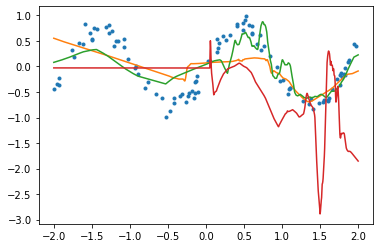

In [12]:

n_data=101
# hidden_layers=[16,32,256,32,16]
hidden_layers=[128,128,256,128]
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3.4)+np.random.randn(x.shape[0],x.shape[1])*0.1
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
for ii in range(3):
    net=BNet6(hidden_layer_sizes=hidden_layers,input_dim=1,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=False,passes=1,total_info=1,failed_attempts=1)
    plt.plot(x_test,net.forward(x_test)[0])

In [ ]:
y.shape,x.shape

In [462]:
np.random.randn(3,1)

array([[-0.02357909],
       [-0.61785435],
       [ 1.9961463 ]])

In [68]:
def test_fun_2d(x):
    y=0.8*np.cos(np.sqrt(x[:,0]**2+x[:,1]**2)*5)
#     y=0.8*np.cos(x[:,0]*5)

    y=y.reshape((y.shape[0],1))+np.random.randn(y.shape[0],1)*0.1

    return y

In [159]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,32,32,32]
n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
# plt.plot(x,y,'.')
for ii in range(1):
    net=BNet6(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=True,passes=10,total_info=3,failed_attempts=10)
#     plt.plot(x_test,net.forward(x_test)[0])

0: Error1: 0.08374988797211583, Error2: 7.221239727055443e-06
1: Error1: 0.27654510612263977, Error2: 0.001205505989833237
2: Error1: 0.0007462801537999159, Error2: 2.2150139515326095e-08
3: Error1: 1.374072133027315, Error2: 4.927662930240083e-07
4: Error1: 1.3951657039591276, Error2: 0.0015230434629957075
5: Error1: 0.08319889263532232, Error2: 0.01045246222549099
6: Error1: 2.197855953057601, Error2: 0.05840191566351461
7: Error1: 0.4229071805549332, Error2: 3.2965798936009764e-05
8: Error1: 0.4459409840370251, Error2: 0.0008093031352398772
9: Error1: 1.0124109018212903, Error2: 0.06747050256403328
10: Error1: 1.0183835895738769, Error2: 0.18053690612441797
11: Error1: 1.0263905765533254, Error2: 0.1497698565429133
12: Error1: 0.5700079455169614, Error2: 0.028707311662457238
13: Error1: 2.9668670160481208, Error2: 0.009267626455584195
14: Error1: 0.18861763999062547, Error2: 0.0501678711665809
15: Error1: 0.6320451101004274, Error2: 0.13604529458787898
16: Error1: 1.2063533217351197

139: Error1: 0.866647459720952, Error2: 0.7396140133805639
140: Error1: 0.13826900836704709, Error2: 0.11619891517669682
141: Error1: 0.8892862233414771, Error2: 0.7734915321252058
142: Error1: 0.002689661628578189, Error2: 0.002363753904089127
143: Error1: 0.08439172683263778, Error2: 0.07243921587061357
144: Error1: 0.005821677743095861, Error2: 0.004336300233149278
145: Error1: 1.0586970335177845, Error2: 0.8922219117517389
146: Error1: 0.5081749587431682, Error2: 0.4163460731118209
147: Error1: 0.7525098033324412, Error2: 0.5612093082302602
148: Error1: 0.5839599288140176, Error2: 0.4852779129942334
149: Error1: 0.051476909519139545, Error2: 0.039771168948123624
150: Error1: 0.08402142691351286, Error2: 0.07117596954550855
151: Error1: 0.06670955858610118, Error2: 0.05809081002315529
152: Error1: 0.7698946327911574, Error2: 0.6451890913906296
153: Error1: 0.038835469818099544, Error2: 0.03004130237985209
154: Error1: 0.11500804202572648, Error2: 0.10326931813401795
155: Error1: 0.0

278: Error1: 0.038822671794076856, Error2: 0.036819569974015025
279: Error1: 0.025306292486285444, Error2: 0.023103190796547227
280: Error1: 0.7967782844890687, Error2: 0.7505216440909511
281: Error1: 0.7007612724539851, Error2: 0.5832038537624566
282: Error1: 0.04749343544059879, Error2: 0.04411385748731243
283: Error1: 0.004442731803262793, Error2: 0.004222320882706545
284: Error1: 0.08753298829505117, Error2: 0.0798143765031905
285: Error1: 0.14670058485091603, Error2: 0.13980423688720384
286: Error1: 0.0016967564174505472, Error2: 0.0015801320012663548
287: Error1: 4.3474632000186015e-05, Error2: 3.927292169009859e-05
288: Error1: 0.07425103913010002, Error2: 0.06801039076672148
289: Error1: 0.6035589204894546, Error2: 0.5648959964652741
290: Error1: 0.5930934884987231, Error2: 0.5611494785350364
291: Error1: 0.37964265005758663, Error2: 0.3306940491193364
292: Error1: 0.1466626527641003, Error2: 0.13535640263421722
293: Error1: 0.5617378345131392, Error2: 0.4706804080391623
294: E

416: Error1: 0.598585504915441, Error2: 0.5625137001605081
417: Error1: 0.48275621639085625, Error2: 0.4490789018643912
418: Error1: 0.39645124210236726, Error2: 0.3575260079171767
419: Error1: 0.009611551946810832, Error2: 0.00895128630503981
420: Error1: 0.5851505089145819, Error2: 0.5596531305960046
421: Error1: 0.0012268706375856613, Error2: 0.001173458678809775
422: Error1: 0.008008910549899172, Error2: 0.007323212997659577
423: Error1: 0.5773381717670109, Error2: 0.5524874037849882
424: Error1: 0.11632258540687772, Error2: 0.10463901092480171
425: Error1: 0.1486741710065598, Error2: 0.13707506765618765
426: Error1: 0.5015729540719605, Error2: 0.4735688294553713
427: Error1: 0.4188325330140323, Error2: 0.3956209999227089
428: Error1: 0.45585572709683503, Error2: 0.4410568106877049
429: Error1: 0.09691848370462357, Error2: 0.09375273237227727
430: Error1: 0.5117221824619856, Error2: 0.4860941202580356
431: Error1: 0.5012840022459483, Error2: 0.4773080710020274
432: Error1: 0.009101

555: Error1: 0.016201491005679705, Error2: 0.015686034004225805
556: Error1: 0.6967781578067122, Error2: 0.6738037773510728
557: Error1: 0.12909449373212992, Error2: 0.12051130021114899
558: Error1: 0.20498513681123365, Error2: 0.19671947922892463
559: Error1: 0.5804114511213205, Error2: 0.5356557571341851
560: Error1: 0.01844163555912268, Error2: 0.017881136467832303
561: Error1: 0.19024279524624765, Error2: 0.18139213382399166
562: Error1: 0.4046670162352723, Error2: 0.3899403758206041
563: Error1: 0.0029708525751601985, Error2: 0.0029022746136355233
564: Error1: 0.1936920818214487, Error2: 0.18624569150856493
565: Error1: 0.1465046663682711, Error2: 0.14281322418445908
566: Error1: 0.05739457425632085, Error2: 0.05344106232888144
567: Error1: 0.7528632430161257, Error2: 0.7257947925888865
568: Error1: 0.11750924817743577, Error2: 0.11407389097021353
569: Error1: 0.3121640583575487, Error2: 0.29987051411120524
570: Error1: 0.6684578111655731, Error2: 0.6444579516290903
571: Error1: 0

693: Error1: 0.20535292605207212, Error2: 0.20119197245676743
694: Error1: 0.5664462595551608, Error2: 0.5546921798138198
695: Error1: 0.6648258144415718, Error2: 0.6509812892760546
696: Error1: 0.35465488121225525, Error2: 0.34679387889077645
697: Error1: 0.7274157757571548, Error2: 0.7115112458684127
698: Error1: 0.3455266525392419, Error2: 0.33805255640033066
699: Error1: 0.3629942178096757, Error2: 0.35302673442742133
700: Error1: 0.5914676613020542, Error2: 0.5826472687975919
701: Error1: 0.02937660472217424, Error2: 0.02869113338597933
702: Error1: 0.209985411901982, Error2: 0.20486219481350001
703: Error1: 0.03677330341499883, Error2: 0.03555775217791347
704: Error1: 0.2296431213328175, Error2: 0.22139664571875248
705: Error1: 0.23620569431830232, Error2: 0.22583067017306993
706: Error1: 0.3252388285440926, Error2: 0.3194888707276059
707: Error1: 0.5106524968908074, Error2: 0.49857016568167756
708: Error1: 0.09406662067509003, Error2: 0.09101305368625483
709: Error1: 0.018539895

828: Error1: 0.09564850312561476, Error2: 0.09232459649578285
829: Error1: 0.7244269482499821, Error2: 0.7058607601473753
830: Error1: 0.0948441066212791, Error2: 0.09916136600069814
831: Error1: 0.31101702298719125, Error2: 0.3029308249107399
832: Error1: 0.14715191117849136, Error2: 0.14468853857735076
833: Error1: 0.46990018235965764, Error2: 0.4541213679631009
834: Error1: 0.19384988854568974, Error2: 0.18926888017841034
835: Error1: 0.42504827263043604, Error2: 0.415092238823838
836: Error1: 0.029373138426297296, Error2: 0.02895503048724899
837: Error1: 0.2566641025848941, Error2: 0.2512916087378128
838: Error1: 0.006674218368106878, Error2: 0.006611998972232608
839: Error1: 0.5775359936538863, Error2: 0.5622665180634709
840: Error1: 0.2653016189264947, Error2: 0.26069459639854525
841: Error1: 0.09493741775892281, Error2: 0.09275990852474134
842: Error1: 0.2076158786980138, Error2: 0.1988499467856549
843: Error1: 0.013208443885934132, Error2: 0.012773848412021113
844: Error1: 0.05

6: Error1: 0.3588626961674217, Error2: 0.3453748708566641
7: Error1: 0.06328456742020494, Error2: 0.062211217359471896
8: Error1: 0.5678794483597861, Error2: 0.5590060079860061
9: Error1: 0.20335191864693405, Error2: 0.1996788316773495
10: Error1: 0.5700671660529134, Error2: 0.5561443031320547
11: Error1: 0.48677628442868637, Error2: 0.47727750248759065
12: Error1: 0.6574245689545416, Error2: 0.6472271058093565
13: Error1: 0.5644965637793988, Error2: 0.5562122910776246
14: Error1: 0.3523910121093748, Error2: 0.34522044314192324
15: Error1: 0.6647956955917029, Error2: 0.6542648750491429
16: Error1: 0.34071216971647866, Error2: 0.33621597728222724
17: Error1: 0.2377971696538464, Error2: 0.23424851451334291
18: Error1: 0.04696428389920947, Error2: 0.04627585507220796
19: Error1: 0.7440630589909064, Error2: 0.7104728488663212
20: Error1: 0.7546255543502383, Error2: 0.7371687227791529
21: Error1: 0.054110907062972204, Error2: 0.0523051794682237
22: Error1: 0.5972594649011842, Error2: 0.5893

146: Error1: 0.5496138332371615, Error2: 0.538728064236731
147: Error1: 0.6344611693143488, Error2: 0.6215519232743085
148: Error1: 0.3753587996117154, Error2: 0.3692225226505796
149: Error1: 0.08434611760943185, Error2: 0.08073227091954478
150: Error1: 0.07494934155507632, Error2: 0.07342526134139521
151: Error1: 0.039767711308158635, Error2: 0.03930103671875445
152: Error1: 0.8454120003632961, Error2: 0.837434260578053
153: Error1: 0.08735695578384656, Error2: 0.08583086735862344
154: Error1: 0.09829631901612092, Error2: 0.09750285887769428
155: Error1: 0.026167302346598444, Error2: 0.02587301531245988
156: Error1: 0.8069291467386642, Error2: 0.7994380827731296
157: Error1: 0.10118189338039316, Error2: 0.09796859313258417
158: Error1: 0.8640635145299319, Error2: 0.8541510275871209
159: Error1: 0.056145395645430904, Error2: 0.05496357187187667
160: Error1: 0.19964403620913512, Error2: 0.1972150701579976
161: Error1: 0.26057469164618957, Error2: 0.2560624571332043
162: Error1: 0.038581

286: Error1: 0.00017969743064342238, Error2: 0.0001804589189328334
287: Error1: 0.01450379580522919, Error2: 0.014339123393506365
288: Error1: 0.053671067655328523, Error2: 0.05335527575494738
289: Error1: 0.5251894959966583, Error2: 0.5213783230804245
290: Error1: 0.5443426429227888, Error2: 0.5404391158851606
291: Error1: 0.22226946770712833, Error2: 0.2195891738423861
292: Error1: 0.05830485907005169, Error2: 0.057612102724409316
293: Error1: 0.793569381374502, Error2: 0.7816218556974045
294: Error1: 0.0008594031698742889, Error2: 0.0008535581441951686
295: Error1: 0.02579411614247351, Error2: 0.025978332786573372
296: Error1: 0.9335014066275491, Error2: 0.9222269879773777
297: Error1: 0.3229296151379614, Error2: 0.3189935416553932
298: Error1: 0.0006953299496070723, Error2: 0.0006990142388997287
299: Error1: 0.5220810891527307, Error2: 0.5183251637061405
300: Error1: 0.2888187331250934, Error2: 0.2923571621362769
301: Error1: 0.32126868527750224, Error2: 0.31758382842416205
302: Er

425: Error1: 0.21501559700272008, Error2: 0.2116062511042961
426: Error1: 0.38695692955556743, Error2: 0.38223467397932914
427: Error1: 0.5221249510696304, Error2: 0.5186567155232313
428: Error1: 0.4636163010029511, Error2: 0.460550124456149
429: Error1: 0.0746202268001739, Error2: 0.07421441960304188
430: Error1: 0.4881166402714064, Error2: 0.48376134999751336
431: Error1: 0.39876826727668885, Error2: 0.3956539662041613
432: Error1: 0.0075968441292505575, Error2: 0.0074906473297867
433: Error1: 0.4565920964934003, Error2: 0.4541589514678256
434: Error1: 4.728700415161188e-05, Error2: 4.763158266100692e-05
435: Error1: 0.0030075485542705466, Error2: 0.002940778576706835
436: Error1: 0.2749278106701567, Error2: 0.2716546873755174
437: Error1: 0.7485424497503382, Error2: 0.744155528398425
438: Error1: 0.20943425815950684, Error2: 0.20820342786198842
439: Error1: 0.20090928797881855, Error2: 0.19903301877546267
440: Error1: 0.3738835380303267, Error2: 0.3713508422758168
441: Error1: 0.605

563: Error1: 0.002360960578953445, Error2: 0.0023692769809071637
564: Error1: 0.05346035732578756, Error2: 0.05329632499660482
565: Error1: 0.19769170381380274, Error2: 0.19674037025121563
566: Error1: 0.05693859890040021, Error2: 0.056443151116886074
567: Error1: 0.5791433229461264, Error2: 0.5707746856960235
568: Error1: 0.14446284788654332, Error2: 0.1435885371178674
569: Error1: 0.20253784359283677, Error2: 0.20028883443513
570: Error1: 0.7580044500628014, Error2: 0.7538008203627863
571: Error1: 0.627966053247932, Error2: 0.6246258848670547
572: Error1: 0.2354434729259412, Error2: 0.23356989474927992
573: Error1: 0.6367706815467808, Error2: 0.6330275385201092
574: Error1: 0.0006688602479365868, Error2: 0.0007052457331109227
575: Error1: 0.0070374927374557365, Error2: 0.0069082691842637075
576: Error1: 0.09369207987055896, Error2: 0.09330713756647276
577: Error1: 0.7597644240016106, Error2: 0.7558525899743705
578: Error1: 0.48649637290015446, Error2: 0.48392202225192515
579: Error1:

703: Error1: 0.02785291931621377, Error2: 0.027673822817728212
704: Error1: 0.08371596109960351, Error2: 0.08307719923291772
705: Error1: 0.3163982356187009, Error2: 0.30941301430194934
706: Error1: 0.32231528372707674, Error2: 0.32096692245607505
707: Error1: 0.5269408658666821, Error2: 0.5244887883127847
708: Error1: 0.05107216705925119, Error2: 0.050482518761162117
709: Error1: 0.03987723867552699, Error2: 0.03941562775929825
710: Error1: 0.004032756514061054, Error2: 0.003977377552421221
711: Error1: 0.014405296536764338, Error2: 0.014357426980447563
712: Error1: 0.5188905701243272, Error2: 0.5116904661460631
713: Error1: 0.2598237638349849, Error2: 0.25788768302013243
714: Error1: 0.09169137496183777, Error2: 0.09131900124287357
715: Error1: 0.29700652045621834, Error2: 0.2957018449854736
716: Error1: 0.0015108108876920195, Error2: 0.001447696164084823
717: Error1: 0.060941265237942695, Error2: 0.03112117251046414
718: Error1: 0.45471888055129633, Error2: 0.4529145742383077
719: E

843: Error1: 0.027127612680575588, Error2: 0.02658949783176317
844: Error1: 0.06258785996649685, Error2: 0.06235805706518396
845: Error1: 0.38931131040117944, Error2: 0.38800019442556066
846: Error1: 0.004787355988283048, Error2: 0.004724758036813494
847: Error1: 0.382971542690826, Error2: 0.3805008802348993
848: Error1: 0.19287981827599518, Error2: 0.19197278105013285
849: Error1: 0.6854143541106587, Error2: 0.6828371338810689
850: Error1: 0.2783412005115248, Error2: 0.27106398705610785
851: Error1: 0.029799417863830134, Error2: 0.029682050112765233
852: Error1: 0.38260401902115443, Error2: 0.3809594819064403
853: Error1: 0.007569697830186803, Error2: 0.007488642780770769
854: Error1: 0.40719271723106154, Error2: 0.40327296124390777
855: Error1: 0.7081174988222472, Error2: 0.7034033158170709
856: Error1: 0.48895803881052374, Error2: 0.4869517049747654
857: Error1: 0.6581973052526909, Error2: 0.6557638646210594
858: Error1: 0.6067271809616083, Error2: 0.6029288404025643
859: Error1: 0.

18: Error1: 0.07120866913407355, Error2: 0.07092869085352556
19: Error1: 0.6120848567400887, Error2: 0.5918346563340271
20: Error1: 0.7818621698422364, Error2: 0.7786331238458485
21: Error1: 0.08521007244818944, Error2: 0.08220902396036951
22: Error1: 0.6585423145105286, Error2: 0.6560550898120319
23: Error1: 0.12592161651155143, Error2: 0.12429122703009211
24: Error1: 0.27456810458992437, Error2: 0.2736141585008327
25: Error1: 0.09237383065018025, Error2: 0.09126390400015535
26: Error1: 0.19233653521459668, Error2: 0.1915436216308651
27: Error1: 0.46744706682345344, Error2: 0.46256548192093006
28: Error1: 0.0012156268538273108, Error2: 0.0016504375954904849
29: Error1: 0.10105098744212102, Error2: 0.10027602972467761
30: Error1: 0.23928793531581652, Error2: 0.22986933913799484
31: Error1: 0.042854658128652, Error2: 0.04271269864649347
32: Error1: 0.753551147507907, Error2: 0.7503465693226529
33: Error1: 0.45070496692801915, Error2: 0.44835633351397436
34: Error1: 0.2528356359656839, E

155: Error1: 0.025119279637042687, Error2: 0.02502937150911879
156: Error1: 0.7915449401002987, Error2: 0.7891984029984648
157: Error1: 0.03995814193630146, Error2: 0.03912820549141153
158: Error1: 0.6324347294164763, Error2: 0.6256221913336053
159: Error1: 0.05539525197520274, Error2: 0.0550641075924351
160: Error1: 0.1854963406330392, Error2: 0.1849563692417546
161: Error1: 0.19778009420730086, Error2: 0.19637772164503578
162: Error1: 0.04006964474327795, Error2: 0.03975196277316209
163: Error1: 0.42361687542275295, Error2: 0.42206774172927025
164: Error1: 1.3862429081364542, Error2: 1.3746655398344665
165: Error1: 0.2501572235260501, Error2: 0.24663490722649706
166: Error1: 0.256836020003598, Error2: 0.25616658393202074
167: Error1: 0.6778910678106014, Error2: 0.6760414032988633
168: Error1: 0.06238444245481945, Error2: 0.0617310362024678
169: Error1: 0.7790376547413168, Error2: 0.7760999563294253
170: Error1: 0.12390535027475419, Error2: 0.12088135247897683
171: Error1: 0.009531004

294: Error1: 0.00022559292061992534, Error2: 0.00022542191144052677
295: Error1: 0.051056672460729736, Error2: 0.04994709004001143
296: Error1: 0.8754270200711688, Error2: 0.872343800705949
297: Error1: 0.145421708077343, Error2: 0.14492011224973728
298: Error1: 0.00045678933268028066, Error2: 0.00046080247717166433
299: Error1: 0.528907470681927, Error2: 0.5275061004879245
300: Error1: 0.2215800799621219, Error2: 0.2352751320100554
301: Error1: 0.32911683806883313, Error2: 0.32732455614834305
302: Error1: 0.04308924412021965, Error2: 0.04295639106283724
303: Error1: 0.18149722301388202, Error2: 0.1810016859103146
304: Error1: 0.3556331212328984, Error2: 0.35460671119131243
305: Error1: 0.004400299415216421, Error2: 0.004387496507108702
306: Error1: 0.015221248686110935, Error2: 0.015236735809727108
307: Error1: 0.4540061561257419, Error2: 0.4527578361991465
308: Error1: 0.29019626133444304, Error2: 0.28949954791819454
309: Error1: 0.18972268287675048, Error2: 0.18077774295202792
310: 

430: Error1: 0.3636268191978139, Error2: 0.3609655296692359
431: Error1: 0.3830379340677319, Error2: 0.3820259508789823
432: Error1: 0.009817939883314355, Error2: 0.009758467765630335
433: Error1: 0.45029476148815367, Error2: 0.44927508553883355
434: Error1: 0.00010941171847940458, Error2: 0.00010914653959204356
435: Error1: 0.0015821529066830514, Error2: 0.0015526531251713828
436: Error1: 0.29826097858358214, Error2: 0.296565441174174
437: Error1: 0.742821824434362, Error2: 0.7409786914854363
438: Error1: 0.20524746323083892, Error2: 0.20486444227759582
439: Error1: 0.1607758930228182, Error2: 0.16038511450693946
440: Error1: 0.35535820384251693, Error2: 0.35443813090244375
441: Error1: 0.6405994456424625, Error2: 0.6382132262674644
442: Error1: 0.0017187956880181621, Error2: 0.0017155147327474985
443: Error1: 0.6243376568277914, Error2: 0.6230241832358894
444: Error1: 0.4153670450009621, Error2: 0.41442383644281683
445: Error1: 0.004130691606569378, Error2: 0.004076491171142657
446: 

564: Error1: 0.009590637803597894, Error2: 0.01008182865570089
565: Error1: 0.19473440889131985, Error2: 0.19434531784080253
566: Error1: 0.056667146841263234, Error2: 0.05648316743777558
567: Error1: 0.4481272060264762, Error2: 0.44302585343368994
568: Error1: 0.1414963075325286, Error2: 0.14117987997441164
569: Error1: 0.15421666769170705, Error2: 0.15323289199994408
570: Error1: 0.7521855321003273, Error2: 0.7506063715328567
571: Error1: 0.611956675186633, Error2: 0.6107184177625941
572: Error1: 0.22416548557443286, Error2: 0.2233507613389154
573: Error1: 0.6283782485902957, Error2: 0.6268921255761669
574: Error1: 0.00041566866999669143, Error2: 0.0003849927410019507
575: Error1: 0.0016142882074422027, Error2: 0.0012571173387014578
576: Error1: 0.09092198305257858, Error2: 0.09076267101007934
577: Error1: 0.7536211415388923, Error2: 0.7520391426620607
578: Error1: 0.5306294426332229, Error2: 0.5294554378085491
579: Error1: 0.10694740714639578, Error2: 0.1066901958410568
580: Error1:

702: Error1: 0.2170813553318146, Error2: 0.21665360752770244
703: Error1: 0.026626312592673992, Error2: 0.026565420357424114
704: Error1: 0.044490817671026486, Error2: 0.04333294244900168
705: Error1: 0.3247823883150625, Error2: 0.31961933233421813
706: Error1: 0.34789150486821047, Error2: 0.34730010100430936
707: Error1: 0.5161649410005049, Error2: 0.5150338450918094
708: Error1: 0.03043274210464774, Error2: 0.030267292899900412
709: Error1: 0.060855915974023275, Error2: 0.06041217395546559
710: Error1: 0.0010660491258732265, Error2: 0.0010533564676975485
711: Error1: 0.02105259156027612, Error2: 0.020999177204528714
712: Error1: 0.5548968954916239, Error2: 0.5494917309940106
713: Error1: 0.3159311625967587, Error2: 0.31447528244716727
714: Error1: 0.09379548676837902, Error2: 0.09360251306394415
715: Error1: 0.3028073318626604, Error2: 0.30232267323423373
716: Error1: 0.008389803097745806, Error2: 0.008253015737414389
717: Error1: 0.12096204121406301, Error2: 0.07498960480796996
not 

843: Error1: 0.06656053057017046, Error2: 0.06563189605954999
844: Error1: 0.05822428247474402, Error2: 0.05812431953647332
not today
845: Error1: 0.4034285977306468, Error2: 0.4034285977306468
846: Error1: 0.0010437671887276892, Error2: 0.0010276122680483602
847: Error1: 0.37885453008811437, Error2: 0.37768442654392775
848: Error1: 0.19150321027933206, Error2: 0.19111961245286996
849: Error1: 0.6861120341139322, Error2: 0.6848560688606837
850: Error1: 0.288965661530388, Error2: 0.28220032672844636
851: Error1: 0.027373156027388983, Error2: 0.027327207166404965
852: Error1: 0.3916453468641555, Error2: 0.39089766251921293
853: Error1: 0.01166775415557481, Error2: 0.011587155418743902
854: Error1: 0.2979001820527107, Error2: 0.29516357896609263
855: Error1: 0.6677916923348546, Error2: 0.664980189221738
856: Error1: 0.4697220178594535, Error2: 0.4689320755878761
857: Error1: 0.6590850107378756, Error2: 0.6578910806938896
858: Error1: 0.5922977228820899, Error2: 0.5904014033785625
859: Err

18: Error1: 0.07539186911031835, Error2: 0.07521583636099163
19: Error1: 0.4624938222974599, Error2: 0.4523227626499644
20: Error1: 0.7717445165441538, Error2: 0.7703909306360401
21: Error1: 0.162075952717137, Error2: 0.15438267824048
22: Error1: 0.6370505527898659, Error2: 0.6357714216777974
23: Error1: 0.17863742551765951, Error2: 0.1757404193945816
24: Error1: 0.2800188486078249, Error2: 0.2795672779381422
25: Error1: 0.08776466665739725, Error2: 0.08726947286504465
26: Error1: 0.18678509678336128, Error2: 0.1864003612841755
27: Error1: 0.46214844535463895, Error2: 0.4599978639578923
28: Error1: 0.004926348614066704, Error2: 0.0042530779554818795
29: Error1: 0.11965141681854038, Error2: 0.1191017188379275
30: Error1: 0.1623558860946507, Error2: 0.15737044001939376
31: Error1: 0.04646660270907679, Error2: 0.04639348945253709
32: Error1: 0.7382086704801376, Error2: 0.7368349258228553
33: Error1: 0.5160295653519168, Error2: 0.514110233276669
34: Error1: 0.20400344007415322, Error2: 0.1

158: Error1: 0.43889880346392, Error2: 0.43356814537221866
159: Error1: 0.05270919547757267, Error2: 0.052562642454872965
160: Error1: 0.18499700371827696, Error2: 0.18474760645279292
161: Error1: 0.17542275573766186, Error2: 0.1747479586968377
162: Error1: 0.04086082015934445, Error2: 0.04067085864672943
163: Error1: 0.40346898727543873, Error2: 0.40270829814392056
164: Error1: 1.4455615112500555, Error2: 1.4374288977917362
165: Error1: 0.22733390208910798, Error2: 0.2250098741138379
166: Error1: 0.24690924737353398, Error2: 0.24656934388075188
167: Error1: 0.6892183689068118, Error2: 0.6881753199637577
168: Error1: 0.04850655780497231, Error2: 0.048146772993356075
169: Error1: 0.7951093780324237, Error2: 0.7935052360570315
170: Error1: 0.2022691306397685, Error2: 0.19455007387339537
171: Error1: 0.010295330504008082, Error2: 0.01026864136912634
172: Error1: 0.26679942944990626, Error2: 0.27235138961272704
173: Error1: 0.6041440895717904, Error2: 0.6026847987496786
174: Error1: 0.2902

294: Error1: 9.631551385203325e-05, Error2: 9.61976218387713e-05
295: Error1: 0.09301784281993203, Error2: 0.08939684736571575
296: Error1: 0.8712960426728324, Error2: 0.8697631389283317
297: Error1: 0.16704945115693035, Error2: 0.16543868740932674
298: Error1: 0.000268355896171062, Error2: 0.0002703459338812056
299: Error1: 0.5426341280278988, Error2: 0.5417746408225884
300: Error1: 0.20981317441620143, Error2: 0.22490011452398345
301: Error1: 0.32031215786504524, Error2: 0.3192529972167628
302: Error1: 0.0454921340447018, Error2: 0.045416596875094764
303: Error1: 0.17031519931330644, Error2: 0.1700700665774835
304: Error1: 0.3553543605738473, Error2: 0.3547991827406839
305: Error1: 0.003620061344038615, Error2: 0.003614289772283651
306: Error1: 0.0004591748194145301, Error2: 0.0004738934081619464
307: Error1: 0.4781081330456983, Error2: 0.47719903260813107
308: Error1: 0.2782997537659025, Error2: 0.2779389898529742
309: Error1: 0.3064853837596028, Error2: 0.2898304313875405
310: Erro

432: Error1: 0.010598974457082817, Error2: 0.010563077228359244
433: Error1: 0.4356988984187102, Error2: 0.43512985485782707
434: Error1: 4.994072978415118e-08, Error2: 4.892008744189134e-08
435: Error1: 0.0009917088818535305, Error2: 0.0009815538092221008
436: Error1: 0.3085956510317181, Error2: 0.30750126835442426
437: Error1: 0.7518313505361859, Error2: 0.7507416665547046
438: Error1: 0.20048279650251272, Error2: 0.20027501081052956
439: Error1: 0.16159261543732814, Error2: 0.16138376140160804
440: Error1: 0.3444853038254734, Error2: 0.34398408489528237
441: Error1: 0.6564407579616459, Error2: 0.6549543818566627
442: Error1: 0.0016214510276588792, Error2: 0.0016198766698406583
443: Error1: 0.6256822450229564, Error2: 0.624945305610524
444: Error1: 0.4053758347880438, Error2: 0.40486250943666735
445: Error1: 0.006921703449804907, Error2: 0.006844494566915479
446: Error1: 0.1354877521467741, Error2: 0.13518033261289653
447: Error1: 3.38153431257819e-05, Error2: 3.5018292334662346e-05


567: Error1: 0.38802003643338356, Error2: 0.3843579656599162
568: Error1: 0.13593525156854355, Error2: 0.1357607218670591
569: Error1: 0.13660421981054613, Error2: 0.13599907811311854
570: Error1: 0.7400595149204031, Error2: 0.7391729630753516
571: Error1: 0.5926554288555994, Error2: 0.5919718780608537
572: Error1: 0.21388332132002869, Error2: 0.2134077623939772
573: Error1: 0.6357985759651418, Error2: 0.634969345769208
574: Error1: 0.006550374527452784, Error2: 0.006445178954668951
575: Error1: 0.020648949103618263, Error2: 0.018559140053800674
576: Error1: 0.08521321730985598, Error2: 0.08512324381002012
577: Error1: 0.7673202985314018, Error2: 0.7663854308780791
578: Error1: 0.5165770556527364, Error2: 0.5159126957897889
579: Error1: 0.14070403595247996, Error2: 0.1404178974917287
580: Error1: 0.568711282610369, Error2: 0.5592444645698963
581: Error1: 0.7688189573047289, Error2: 0.7678296030751943
582: Error1: 0.3839333883385243, Error2: 0.38349448209142156
583: Error1: 0.1346656047

702: Error1: 0.2178359380947032, Error2: 0.21758914689377867
703: Error1: 0.02526977774281586, Error2: 0.025239084836959504
704: Error1: 0.08301387936402635, Error2: 0.08204336385983106
705: Error1: 0.2774245134340743, Error2: 0.27393106846049303
not today
706: Error1: 0.33936838999163266, Error2: 0.33936838999163266
707: Error1: 0.49963189895382115, Error2: 0.498933854251901
708: Error1: 0.02557398411657201, Error2: 0.02546596824280615
709: Error1: 0.06999813422588003, Error2: 0.06961362252640207
710: Error1: 0.001600253702023459, Error2: 0.0015869181183880553
711: Error1: 0.017404523279674344, Error2: 0.017375424510158367
712: Error1: 0.5413314230464764, Error2: 0.5371164979581402
713: Error1: 0.3613115492219376, Error2: 0.3600502654194444
714: Error1: 0.09918447463051715, Error2: 0.09904697365081133
715: Error1: 0.30034928219062873, Error2: 0.3000634974173045
716: Error1: 0.019518710119093684, Error2: 0.019347263188913215
717: Error1: 0.16139220264100135, Error2: 0.10939458974092432

836: Error1: 0.030239333536127195, Error2: 0.030220852288828575
837: Error1: 0.23257977522143883, Error2: 0.2319574494982722
838: Error1: 0.007922804680129902, Error2: 0.007916807927246527
839: Error1: 0.36071498456569956, Error2: 0.35887699568428316
840: Error1: 0.2733670396352401, Error2: 0.27305963345273676
841: Error1: 0.19941051049665484, Error2: 0.19367009036271807
842: Error1: 0.0070707722220701, Error2: 0.0069173777898559295
843: Error1: 0.08838650980212592, Error2: 0.08746857975209181
844: Error1: 0.05183614243973026, Error2: 0.051781628969771856
not today
845: Error1: 0.38831733330969653, Error2: 0.38831733330969653
846: Error1: 0.00029254746863287474, Error2: 0.0002863485566997977
847: Error1: 0.3703307251721014, Error2: 0.3696381810511834
848: Error1: 0.18966869694191832, Error2: 0.1894459261777508
849: Error1: 0.7040308789131777, Error2: 0.703232225290754
850: Error1: 0.22586947625717782, Error2: 0.22145206568782483
851: Error1: 0.03343885121795243, Error2: 0.0334079284731

10: Error1: 0.4775449830058477, Error2: 0.47585703997358547
11: Error1: 0.4276915420139723, Error2: 0.42643140354581144
12: Error1: 0.5686428995011861, Error2: 0.5672226397212272
13: Error1: 0.5088646507118897, Error2: 0.508260892227489
14: Error1: 0.28441653120675725, Error2: 0.2840381879252739
15: Error1: 0.5864429774483322, Error2: 0.5852792151845809
16: Error1: 0.39241001417071625, Error2: 0.3920165956321818
17: Error1: 0.2053267035119835, Error2: 0.20507682549081704
18: Error1: 0.06561779041447476, Error2: 0.06552075102362012
19: Error1: 0.3550381722560763, Error2: 0.3496407755829304
20: Error1: 0.7856171272635725, Error2: 0.784758651901836
21: Error1: 0.26039109333995225, Error2: 0.24661251540545673
22: Error1: 0.5957724474887515, Error2: 0.5949937619887282
23: Error1: 0.2759092598052156, Error2: 0.27291224182563556
24: Error1: 0.289373264512916, Error2: 0.2890820265156315
25: Error1: 0.08861374647434546, Error2: 0.08833120454484103
26: Error1: 0.1930603442204568, Error2: 0.19280

147: Error1: 0.6433365678258088, Error2: 0.6415549707151283
148: Error1: 0.35946249557774185, Error2: 0.35906191749586625
149: Error1: 0.3225725280308514, Error2: 0.30773491992732716
150: Error1: 0.07287334617831373, Error2: 0.07229099318300841
151: Error1: 0.03764359034412663, Error2: 0.037607208677549644
152: Error1: 0.8640503607425705, Error2: 0.8626370322802304
153: Error1: 0.08732249707781825, Error2: 0.087163651446842
154: Error1: 0.0801310484310604, Error2: 0.08006047992782399
not today
155: Error1: 0.026532594686458338, Error2: 0.026532594686458338
156: Error1: 0.7498189688221802, Error2: 0.7491312232993422
157: Error1: 0.05346133538459516, Error2: 0.05251051200576419
158: Error1: 0.3731373166118606, Error2: 0.36960543886318037
159: Error1: 0.05505348167798847, Error2: 0.05495424543318413
160: Error1: 0.17873550722672568, Error2: 0.17859507731417595
161: Error1: 0.17167048463810694, Error2: 0.1712450680043021
162: Error1: 0.040928701042392074, Error2: 0.04079620702177843
163: E

286: Error1: 0.010901940019617319, Error2: 0.010880954457679497
287: Error1: 0.04132022048701023, Error2: 0.041229207345174594
288: Error1: 0.06708334556526299, Error2: 0.0670420416783131
289: Error1: 0.5272760687537544, Error2: 0.5267479238947845
not today
290: Error1: 0.5739788254031057, Error2: 0.5739788254031057
291: Error1: 0.20506250670235246, Error2: 0.20462219383794678
292: Error1: 0.04718306350111167, Error2: 0.047094185033599335
293: Error1: 0.8386234600434175, Error2: 0.8371813914656568
not today
294: Error1: 2.2220538613794726e-06, Error2: 2.2220538613794726e-06
295: Error1: 0.12163897606613716, Error2: 0.11595397829022659
296: Error1: 0.8834209934490213, Error2: 0.8823879763609378
297: Error1: 0.2776314192081594, Error2: 0.27408663927686755
298: Error1: 2.492037976799921e-05, Error2: 2.5521027534581123e-05
299: Error1: 0.5566625244716035, Error2: 0.5560259890104643
300: Error1: 0.2325039452542442, Error2: 0.24649099468778954
301: Error1: 0.30405956679588086, Error2: 0.3033

425: Error1: 0.2903030435755274, Error2: 0.2893221246063909
426: Error1: 0.3267190776274165, Error2: 0.3255300929477022
427: Error1: 0.5413984648291992, Error2: 0.5409206223873946
428: Error1: 0.5149293198764987, Error2: 0.5143307296949905
429: Error1: 0.07857394485137335, Error2: 0.07851194591807834
430: Error1: 0.17621127497740677, Error2: 0.1743825461679776
431: Error1: 0.3594134355918996, Error2: 0.35906649042745975
432: Error1: 0.010835811984277325, Error2: 0.010811107746782397
433: Error1: 0.42107307552539286, Error2: 0.420689177664555
not today
434: Error1: 0.00016397020777012537, Error2: 0.00016397020777012537
435: Error1: 0.001158102030173472, Error2: 0.0011503339086358373
436: Error1: 0.31441147987816925, Error2: 0.31360187888173585
437: Error1: 0.7684146578850904, Error2: 0.767648826438974
438: Error1: 0.1914985973273494, Error2: 0.19136389993280375
439: Error1: 0.17002684950983893, Error2: 0.16987935833657125
440: Error1: 0.3333269664517511, Error2: 0.3329963652462611
441: 

558: Error1: 0.16486558680780697, Error2: 0.16996020632247283
559: Error1: 0.49929521274521504, Error2: 0.4977492433666495
560: Error1: 0.012480302132869178, Error2: 0.012470145181137583
561: Error1: 0.3372124371843299, Error2: 0.33325535885542207
562: Error1: 0.4139670369918585, Error2: 0.4136133280705928
563: Error1: 0.03138603929142779, Error2: 0.031131797780122792
564: Error1: 0.06694396789550756, Error2: 0.0664926056394143
565: Error1: 0.17358394115287273, Error2: 0.17344385388315903
566: Error1: 0.06181168822400948, Error2: 0.06175753686858571
567: Error1: 0.35641286521054444, Error2: 0.3535664272893954
568: Error1: 0.12946208772520593, Error2: 0.12934659015111039
569: Error1: 0.13144713201038055, Error2: 0.13100125810718075
570: Error1: 0.7249837824346895, Error2: 0.7243811419941797
571: Error1: 0.5772193292796043, Error2: 0.5767500109824937
572: Error1: 0.20408909685274793, Error2: 0.2037625316076595
573: Error1: 0.6491390822836192, Error2: 0.6485526425031181
574: Error1: 0.016

697: Error1: 0.7242001214164608, Error2: 0.722608145636316
698: Error1: 0.33110929499922875, Error2: 0.330779216279968
699: Error1: 0.3328555351133658, Error2: 0.3325891498609659
not today
700: Error1: 0.5763748397850127, Error2: 0.5763748397850127
701: Error1: 0.02755338603061538, Error2: 0.027535781978260208
702: Error1: 0.22126910233688724, Error2: 0.22109711369079407
703: Error1: 0.023981593455249226, Error2: 0.023961997965941048
704: Error1: 0.1402562058570251, Error2: 0.13924651525528806
705: Error1: 0.2228489105518552, Error2: 0.2205431088307067
not today
706: Error1: 0.328480868047085, Error2: 0.328480868047085
707: Error1: 0.4885905434469516, Error2: 0.48807382329468296
708: Error1: 0.024710591394366137, Error2: 0.024622143301111288
709: Error1: 0.07313938829927913, Error2: 0.07281684469756464
710: Error1: 0.004258745428805225, Error2: 0.004234294764648928
711: Error1: 0.013965597612022413, Error2: 0.01394833142287288
712: Error1: 0.5125195272853456, Error2: 0.5091837190937166

831: Error1: 0.2267497355244048, Error2: 0.2243310347223807
832: Error1: 0.130558663541102, Error2: 0.1304357493264218
833: Error1: 0.6122493552082438, Error2: 0.6073293988803437
834: Error1: 0.17068142827933958, Error2: 0.17058447774807375
835: Error1: 0.4017428301115593, Error2: 0.40142474984991666
836: Error1: 0.02857012146610537, Error2: 0.02855723316134304
837: Error1: 0.2161756268102272, Error2: 0.21573924651822207
838: Error1: 0.006781327482885667, Error2: 0.00677732790534834
839: Error1: 0.36070422290962695, Error2: 0.3594096404429223
840: Error1: 0.2751482749409449, Error2: 0.2749251049025216
841: Error1: 0.23534471855574188, Error2: 0.22705155182773104
842: Error1: 0.0001569855725196649, Error2: 0.00015242801362155224
843: Error1: 0.07593347652482473, Error2: 0.07532320426488769
844: Error1: 0.04740680476264143, Error2: 0.0473710144343519
not today
845: Error1: 0.3764574525169039, Error2: 0.3764574525169039
846: Error1: 0.00016908060797351848, Error2: 0.0001652120438940733
84

6: Error1: 0.4642233352156967, Error2: 0.4582621838693328
7: Error1: 0.08562964164692846, Error2: 0.08555573108050431
8: Error1: 0.6846660751800536, Error2: 0.6839367235924757
9: Error1: 0.15381183964264297, Error2: 0.15361225401382095
10: Error1: 0.48342078628705915, Error2: 0.4821448834789132
11: Error1: 0.40448650863068547, Error2: 0.4035828852404376
12: Error1: 0.5685852087541912, Error2: 0.5674606014793221
13: Error1: 0.48949299982111877, Error2: 0.4890764030104325
14: Error1: 0.30279785136760895, Error2: 0.30252086103162273
15: Error1: 0.5650489517152075, Error2: 0.564159445644518
16: Error1: 0.40236024008026877, Error2: 0.40206588714790537
17: Error1: 0.20009946952787844, Error2: 0.1999095478279084
18: Error1: 0.05219810697004154, Error2: 0.052150865349575116
19: Error1: 0.2958350856435627, Error2: 0.29263388545751057
20: Error1: 0.7997571666525527, Error2: 0.7991269360455844
21: Error1: 0.22937975658991694, Error2: 0.22215555627333983
22: Error1: 0.5640656033477975, Error2: 0.5

142: Error1: 0.002318502608321741, Error2: 0.0023087601021767284
143: Error1: 0.27203188267212447, Error2: 0.27182958186926015
not today
144: Error1: 0.00647144385434281, Error2: 0.00647144385434281
145: Error1: 0.5665317270425223, Error2: 0.5661203330977816
146: Error1: 0.6847936818839871, Error2: 0.6826289739135737
147: Error1: 0.6451494448481799, Error2: 0.6437761973922214
148: Error1: 0.3682492148484931, Error2: 0.36795786875717024
149: Error1: 0.24717928995703894, Error2: 0.23725320248106457
150: Error1: 0.08526327312194391, Error2: 0.08475109061824695
151: Error1: 0.034572468274735965, Error2: 0.03454622705248668
152: Error1: 0.8461511058705713, Error2: 0.844864165622082
153: Error1: 0.08414394635922005, Error2: 0.08403112745736492
154: Error1: 0.0757655435294676, Error2: 0.07571440355410719
not today
155: Error1: 0.02952625389069469, Error2: 0.02952625389069469
156: Error1: 0.7323026978994288, Error2: 0.7317945796212454
157: Error1: 0.07178801270948498, Error2: 0.070809026551859

280: Error1: 0.8434045479658376, Error2: 0.8428209525340438
281: Error1: 0.46005256154278806, Error2: 0.4541297494561462
282: Error1: 0.003340525351330083, Error2: 0.003340989447365264
283: Error1: 0.00408815011038055, Error2: 0.004087010368476089
284: Error1: 0.05014766667601, Error2: 0.05011062918934302
285: Error1: 0.08596643066321882, Error2: 0.08590315956318474
286: Error1: 0.01574794552520614, Error2: 0.015723229261620394
287: Error1: 0.041883134891747234, Error2: 0.04181053564711632
288: Error1: 0.06523569269420855, Error2: 0.06520372371261185
289: Error1: 0.5110833804912324, Error2: 0.5107022484219335
not today
290: Error1: 0.5869296815147003, Error2: 0.5869296815147003
291: Error1: 0.20575951358991695, Error2: 0.20541199340116897
292: Error1: 0.05158874587464808, Error2: 0.05151464377897453
293: Error1: 0.8507703104866113, Error2: 0.8498476522650658
not today
294: Error1: 5.006656938924626e-05, Error2: 5.006656938924626e-05
295: Error1: 0.16242787780108398, Error2: 0.156928366

416: Error1: 0.4067467369424185, Error2: 0.40644149800086266
417: Error1: 0.6093997706610682, Error2: 0.608981071981758
418: Error1: 0.22929274832912844, Error2: 0.22703086992556507
419: Error1: 0.025657928782433715, Error2: 0.025556647903173267
420: Error1: 0.6112256520597626, Error2: 0.6102119205074124
421: Error1: 0.0014675788547261876, Error2: 0.0014653344756724673
422: Error1: 0.052695400507475496, Error2: 0.052568013133059754
423: Error1: 0.15307457721993312, Error2: 0.15219025665574767
424: Error1: 0.4133160920632894, Error2: 0.4097600263324809
425: Error1: 0.2915995100461467, Error2: 0.29077661807899857
426: Error1: 0.3324935259896938, Error2: 0.3315188874643093
427: Error1: 0.552855561672226, Error2: 0.5524897223489263
428: Error1: 0.5533433644154384, Error2: 0.5526517371147242
429: Error1: 0.07534135168176086, Error2: 0.07529402738252702
430: Error1: 0.12226842761833387, Error2: 0.1208259658186258
431: Error1: 0.34798502396997555, Error2: 0.34772725940830895
432: Error1: 0.01

548: Error1: 0.0007913062371040771, Error2: 0.0007907274755231257
549: Error1: 0.22659950406711604, Error2: 0.22606434781275817
550: Error1: 2.3443686431503515e-05, Error2: 2.400300217700522e-05
551: Error1: 0.011021561173154485, Error2: 0.011046450305001457
552: Error1: 0.005249446177955401, Error2: 0.005239230954753994
553: Error1: 0.29095190654401276, Error2: 0.28889074622782646
554: Error1: 0.3548042654567954, Error2: 0.35456178336681365
555: Error1: 0.08985526420486213, Error2: 0.08968992571494035
556: Error1: 0.7706511171236727, Error2: 0.7700310081016739
557: Error1: 0.1746433310186531, Error2: 0.17318173003930828
558: Error1: 0.19883837511993155, Error2: 0.20137180430145377
559: Error1: 0.4903732833759058, Error2: 0.48912529605912475
560: Error1: 0.014057386404737996, Error2: 0.014048292223149886
561: Error1: 0.29849346541285704, Error2: 0.2955902640741977
562: Error1: 0.40746852434967906, Error2: 0.40719775796365437
563: Error1: 0.02203194831575509, Error2: 0.02189360491040656

686: Error1: 0.13860715134336465, Error2: 0.13775857066815797
687: Error1: 0.7305966772440776, Error2: 0.7301127534641358
688: Error1: 0.023629372970466946, Error2: 0.023615677354448035
689: Error1: 0.21778736852399447, Error2: 0.21601138507652862
690: Error1: 0.01791667874253528, Error2: 0.017908777112939114
not today
691: Error1: 0.5759395211535332, Error2: 0.5759395211535332
692: Error1: 0.11070284899115708, Error2: 0.11063651106247907
693: Error1: 0.22557038792828407, Error2: 0.22533508350639245
694: Error1: 0.5228023176132178, Error2: 0.5224602186805188
695: Error1: 0.6511543519485866, Error2: 0.6507523633423985
696: Error1: 0.35220028600136255, Error2: 0.35193146878931647
697: Error1: 0.7059072078838872, Error2: 0.7046319694323206
698: Error1: 0.33361465407783136, Error2: 0.33335405043073413
699: Error1: 0.3261985303234356, Error2: 0.3259926503239907
not today
700: Error1: 0.5869813477218159, Error2: 0.5869813477218159
701: Error1: 0.030357355526614234, Error2: 0.0303416675840052

818: Error1: 0.4754060850657862, Error2: 0.47510759123193896
819: Error1: 0.21969843918133106, Error2: 0.21958619030966775
820: Error1: 0.37882809709522175, Error2: 0.37853288921191985
821: Error1: 0.09413062094109216, Error2: 0.09396916740857637
822: Error1: 0.07723881067694058, Error2: 0.0770192790530762
823: Error1: 0.5215054467015738, Error2: 0.5210615255725873
824: Error1: 0.9274691991856663, Error2: 0.9267636482583461
825: Error1: 0.24552639283597524, Error2: 0.24537716209858385
826: Error1: 0.568402498725376, Error2: 0.5669141076068956
827: Error1: 0.626849275760951, Error2: 0.6264538349582558
828: Error1: 0.00039041428120307635, Error2: 0.0003992411510070222
829: Error1: 0.7120052311742823, Error2: 0.7115664065999248
830: Error1: 0.011250756940951739, Error2: 0.017656544838659975
831: Error1: 0.2922195994149677, Error2: 0.2899137659947736
832: Error1: 0.12275466856878463, Error2: 0.122664898091023
833: Error1: 0.5687778282916823, Error2: 0.5650804168174242
834: Error1: 0.167381

957: Error1: 0.2882772434729118, Error2: 0.28777498568001747
958: Error1: 0.20594154998780645, Error2: 0.2057127175745474
959: Error1: 0.5974706631766087, Error2: 0.5971160582244801
960: Error1: 0.2358697182124768, Error2: 0.23568631574029364
5651.0
0
0: Error1: 0.170581967769259, Error2: 0.17046155681399042
not today
1: Error1: 0.8483184952409031, Error2: 0.8483184952409031
2: Error1: 0.5899648171127154, Error2: 0.5896149097070591
3: Error1: 0.4505071671498412, Error2: 0.44650293388496265
4: Error1: 0.6036895504063143, Error2: 0.6033302163170123
5: Error1: 0.2936965433453667, Error2: 0.291584246663232
6: Error1: 0.5433466208266132, Error2: 0.537083838547299
7: Error1: 0.08857476308537635, Error2: 0.08851413931763234
8: Error1: 0.6590587813085931, Error2: 0.6585361083950219
9: Error1: 0.14791183173678576, Error2: 0.14775477194388373
10: Error1: 0.4876087851791585, Error2: 0.48658553586604525
11: Error1: 0.38401009311728646, Error2: 0.38330360757292536
12: Error1: 0.5775680819364487, Er

130: Error1: 0.0002653004504250264, Error2: 0.00025758625947300176
131: Error1: 0.6756277606556634, Error2: 0.6749577366387335
132: Error1: 0.24289388916714502, Error2: 0.24268289976271068
133: Error1: 0.014020567621658564, Error2: 0.01400642782450762
134: Error1: 0.41921545100078855, Error2: 0.4189689663232387
135: Error1: 0.18806609216372586, Error2: 0.18763781103105515
136: Error1: 0.07099310935470571, Error2: 0.07035901626059861
137: Error1: 0.5380047986031442, Error2: 0.5376921194472655
138: Error1: 0.3716498688562479, Error2: 0.3696094878579592
139: Error1: 0.9550323256475112, Error2: 0.9543021465493252
140: Error1: 0.03392447102246671, Error2: 0.03366769635301145
141: Error1: 0.671231750061652, Error2: 0.6693370896469331
142: Error1: 0.0026060021690543066, Error2: 0.002596854439739142
143: Error1: 0.2782710531065529, Error2: 0.27810282441487705
not today
144: Error1: 0.007703887768956369, Error2: 0.007703887768956369
145: Error1: 0.5564908359120491, Error2: 0.5561580381781361
14

264: Error1: 0.3732382406805082, Error2: 0.3697605448168018
265: Error1: 0.19418798982714322, Error2: 0.19403263471575927
266: Error1: 0.045871589210940714, Error2: 0.045596646536365595
267: Error1: 0.36858337991962603, Error2: 0.3660747645429466
268: Error1: 1.0732274498890301e-05, Error2: 1.0733298594750309e-05
269: Error1: 0.03802371368148673, Error2: 0.03798882371258085
270: Error1: 0.5297465666048721, Error2: 0.5256254300393097
271: Error1: 0.3360612428635885, Error2: 0.33565199719570593
272: Error1: 0.4634219691404369, Error2: 0.46314087895245304
273: Error1: 0.5583121711663694, Error2: 0.5579646370840216
274: Error1: 0.47007838921053763, Error2: 0.46979438713363214
275: Error1: 0.015162654430817444, Error2: 0.014692909873703097
276: Error1: 0.38520109760744514, Error2: 0.38491733908486153
277: Error1: 0.10302643294597907, Error2: 0.10254542687782825
278: Error1: 0.045392871053237395, Error2: 0.045368697092779416
279: Error1: 5.93973954996807e-06, Error2: 6.015646642047028e-06
28

399: Error1: 0.01796357575745881, Error2: 0.017954098841398463
400: Error1: 0.4828097457223902, Error2: 0.47965363770195946
not today
401: Error1: 0.10967022915241596, Error2: 0.10967022915241596
402: Error1: 0.18939853316759214, Error2: 0.1890393965710432
403: Error1: 0.28652046755106947, Error2: 0.286247544890136
404: Error1: 0.20247089112495165, Error2: 0.20235430371043647
405: Error1: 0.18429756453597518, Error2: 0.1836504859677891
406: Error1: 0.0023395584288040975, Error2: 0.002344838242152901
407: Error1: 0.20501561683898223, Error2: 0.20483767928921054
408: Error1: 0.37763318224303066, Error2: 0.37691162231196407
not today
409: Error1: 0.008305562972698194, Error2: 0.008305562972698194
410: Error1: 0.1492995644667911, Error2: 0.14879469612924845
411: Error1: 0.12513239420468708, Error2: 0.12491904064757056
412: Error1: 0.6625528850300934, Error2: 0.661654365115881
413: Error1: 0.555270423541621, Error2: 0.5510366191025973
414: Error1: 0.26594307475218, Error2: 0.265808975331785

538: Error1: 0.8755866220161164, Error2: 0.8741104847270366
539: Error1: 0.04100426221705803, Error2: 0.04098558168840406
540: Error1: 0.24517919494891563, Error2: 0.24502352378055484
541: Error1: 0.8004328370016888, Error2: 0.7993925397530823
542: Error1: 0.703824430830228, Error2: 0.6991921755569471
543: Error1: 0.555312775737914, Error2: 0.53649797675727
544: Error1: 0.07730102093087046, Error2: 0.07702380955045832
545: Error1: 0.30312338631952207, Error2: 0.30291039663025765
546: Error1: 0.2270428138731009, Error2: 0.22618083046252457
not today
547: Error1: 0.5993123832088594, Error2: 0.5993123832088594
548: Error1: 0.0005827772454800804, Error2: 0.0005823139374072034
549: Error1: 0.21974807684946285, Error2: 0.21925700349243837
550: Error1: 6.913290215199661e-06, Error2: 7.162679256060452e-06
551: Error1: 0.013389747224052175, Error2: 0.013410006281621239
552: Error1: 0.008439807785747815, Error2: 0.008424877970160111
553: Error1: 0.32147726872398086, Error2: 0.31943281889111547
5

676: Error1: 0.09599929886724703, Error2: 0.09591490378106052
677: Error1: 0.2512538637822319, Error2: 0.2507286384902747
678: Error1: 0.24271198032880195, Error2: 0.24219702763310316
679: Error1: 0.5652911390969599, Error2: 0.5621654431385188
680: Error1: 0.005361225342045493, Error2: 0.005358271459767822
681: Error1: 0.06162122060400468, Error2: 0.061485325073292546
682: Error1: 0.16345260253041263, Error2: 0.1633616757513579
683: Error1: 0.39285547706024043, Error2: 0.39257443780354856
684: Error1: 0.009791204039576786, Error2: 0.009723449065011838
685: Error1: 0.0018273795187826094, Error2: 0.0018249034406906959
686: Error1: 0.12751907159475104, Error2: 0.1268890024616767
687: Error1: 0.7306572908836253, Error2: 0.7302448093049647
688: Error1: 0.026079973217316955, Error2: 0.026067177227361946
689: Error1: 0.20066758614210525, Error2: 0.19967195149281344
690: Error1: 0.020596729522027884, Error2: 0.020588397421854313
not today
691: Error1: 0.5844945856253252, Error2: 0.584494585625

809: Error1: 0.00010672783716246278, Error2: 0.00010668100975754211
810: Error1: 0.5615367990460528, Error2: 0.5606239470335388
811: Error1: 0.28958695424886777, Error2: 0.2894290950505322
812: Error1: 0.018113117500215895, Error2: 0.017951228207847596
813: Error1: 0.1003202185115119, Error2: 0.10025058387643156
814: Error1: 0.48947858259312566, Error2: 0.48744035644812694
815: Error1: 0.4115473515885144, Error2: 0.40795395237905796
816: Error1: 0.06610651187514835, Error2: 0.06573404845998555
817: Error1: 0.3366155735002454, Error2: 0.33501579752841293
818: Error1: 0.4841396440922104, Error2: 0.4838862887926608
819: Error1: 0.21818843840828653, Error2: 0.21808479972444236
820: Error1: 0.38509964882175074, Error2: 0.38485527276271275
821: Error1: 0.08804155353411322, Error2: 0.08790971988356093
822: Error1: 0.07919996000421452, Error2: 0.0790015977234195
823: Error1: 0.5156387301845821, Error2: 0.5152828290648409
824: Error1: 0.9306135982730727, Error2: 0.9299965113342322
825: Error1: 

949: Error1: 0.06357477892127929, Error2: 0.06351952398319047
950: Error1: 0.3629762295171366, Error2: 0.3627472023127305
951: Error1: 0.7877717628978922, Error2: 0.7873367981742616
952: Error1: 0.2506033744644276, Error2: 0.25045599813975616
953: Error1: 0.08009257926146376, Error2: 0.07937969927485594
954: Error1: 0.4597367559954838, Error2: 0.45876668462771164
955: Error1: 0.002975603630082715, Error2: 0.002973066663721038
956: Error1: 0.48903686366519383, Error2: 0.4874219263810067
957: Error1: 0.2935243095839859, Error2: 0.2930766737289547
958: Error1: 0.21352984230597824, Error2: 0.21335818796073366
959: Error1: 0.588436461053547, Error2: 0.5881343844137118
960: Error1: 0.2396876854758408, Error2: 0.23952048197635153
6555.0
0
0: Error1: 0.17338182167926042, Error2: 0.17327590950724397
not today
1: Error1: 0.8580362724621534, Error2: 0.8580362724621534
2: Error1: 0.5972456705853855, Error2: 0.5969408847828516
3: Error1: 0.4630796797298659, Error2: 0.4596947751933185
4: Error1: 0.5

124: Error1: 0.004721462682953041, Error2: 0.004682710578066583
125: Error1: 0.40917349104712225, Error2: 0.4089657995630753
126: Error1: 0.39364920915377516, Error2: 0.392144520822882
127: Error1: 0.32411056502769936, Error2: 0.32394755823746846
128: Error1: 0.05260668767557397, Error2: 0.05257996212362427
129: Error1: 0.49735453933905477, Error2: 0.4970918555758116
130: Error1: 0.00030253633935417, Error2: 0.0002952774121193621
131: Error1: 0.6697994333196134, Error2: 0.6691502615298789
132: Error1: 0.23876078890043143, Error2: 0.2385603193966718
133: Error1: 0.012941937512573824, Error2: 0.012928123870538016
134: Error1: 0.4151274736902939, Error2: 0.4149161039467361
135: Error1: 0.18024046466378574, Error2: 0.1798877988508985
136: Error1: 0.05093488163457223, Error2: 0.05056376861851157
137: Error1: 0.5337866871735537, Error2: 0.5335176943714397
138: Error1: 0.40051820679620853, Error2: 0.39872553989483117
139: Error1: 0.9573995233342794, Error2: 0.9567567196662725
140: Error1: 0.0

260: Error1: 0.6686040935026007, Error2: 0.6677116498560425
261: Error1: 0.1732712874372401, Error2: 0.17318795159661138
262: Error1: 0.3610935430405444, Error2: 0.36039785430298976
263: Error1: 0.23373716065589736, Error2: 0.2335425737369541
264: Error1: 0.42375328726540856, Error2: 0.42018615491954914
265: Error1: 0.19472622418435157, Error2: 0.19455740877467761
266: Error1: 0.03871193036162798, Error2: 0.038517956244285396
267: Error1: 0.39818376037415704, Error2: 0.3959794992055663
268: Error1: 1.9816465504873483e-06, Error2: 1.9803887865007213e-06
269: Error1: 0.03851568638354545, Error2: 0.03848526391864097
270: Error1: 0.48107459402365144, Error2: 0.47797196728372515
271: Error1: 0.3322562473621283, Error2: 0.33189699713035953
272: Error1: 0.4606478092276597, Error2: 0.4603989719059061
273: Error1: 0.5475200569870255, Error2: 0.5472322101453303
274: Error1: 0.46251492297562136, Error2: 0.4622622474659253
275: Error1: 0.0032058155543166957, Error2: 0.0031079921785056737
276: Erro

395: Error1: 0.3103741874451854, Error2: 0.3100391608718935
396: Error1: 0.47794389712045765, Error2: 0.4777029321648683
397: Error1: 0.06258735168190364, Error2: 0.06255740003806931
398: Error1: 0.6969932640288458, Error2: 0.690256067339357
399: Error1: 0.019706665630704712, Error2: 0.019697467040555857
400: Error1: 0.5317471224645394, Error2: 0.5284410318142353
not today
401: Error1: 0.11248398324119085, Error2: 0.11248398324119085
402: Error1: 0.19579814378536656, Error2: 0.19548074722445435
403: Error1: 0.285918171082712, Error2: 0.2856722795747219
404: Error1: 0.20024132035580616, Error2: 0.2001382279302709
405: Error1: 0.19137012811957058, Error2: 0.19084304999295837
406: Error1: 0.003537585501756255, Error2: 0.003541756341363403
407: Error1: 0.20382708469744112, Error2: 0.20366590961871142
408: Error1: 0.387269962724268, Error2: 0.3866243843781847
not today
409: Error1: 0.007548922827294995, Error2: 0.007548922827294995
410: Error1: 0.15104557737311755, Error2: 0.150632113296724

529: Error1: 0.5309636101935317, Error2: 0.5306914711487255
530: Error1: 0.011797549114368706, Error2: 0.01178382817154038
531: Error1: 0.2639566433775051, Error2: 0.26334713023409373
532: Error1: 0.29959599608920395, Error2: 0.29945246714898927
533: Error1: 0.08842169371514716, Error2: 0.08814228726053501
534: Error1: 0.0032678847834550664, Error2: 0.0032700527504515475
535: Error1: 0.15789801883810353, Error2: 0.15770927896962528
not today
536: Error1: 0.8330483304268472, Error2: 0.8330483304268472
537: Error1: 0.3156234937949314, Error2: 0.3154661304309719
538: Error1: 0.8636425698230766, Error2: 0.8623305293345376
539: Error1: 0.04566645549605167, Error2: 0.045644524606044116
540: Error1: 0.23733256035280945, Error2: 0.23720463777617676
541: Error1: 0.8083891012973057, Error2: 0.8073769048883684
542: Error1: 0.6977412221337501, Error2: 0.693659865855812
543: Error1: 0.4920701126053059, Error2: 0.4803030843997679
544: Error1: 0.07369534670835266, Error2: 0.07347049596697314
545: Err

666: Error1: 0.34921927783608847, Error2: 0.3490516490790693
667: Error1: 0.08225920952089195, Error2: 0.0817281019616617
668: Error1: 0.37396837729651405, Error2: 0.3735264723761962
669: Error1: 0.46618926593212395, Error2: 0.46558341149048293
670: Error1: 0.182801031510868, Error2: 0.18152206784097114
671: Error1: 0.13943249975983218, Error2: 0.1392455933134084
672: Error1: 0.2082271746096616, Error2: 0.20813867580115808
673: Error1: 0.002664009073213409, Error2: 0.00266293004386991
674: Error1: 0.00983335905786381, Error2: 0.014812391156213852
675: Error1: 0.3037803925188317, Error2: 0.3035952931714894
676: Error1: 0.09635374091966975, Error2: 0.09627739061934876
677: Error1: 0.24469665067792273, Error2: 0.2442528584530325
678: Error1: 0.24613695914227637, Error2: 0.2456802631300061
679: Error1: 0.5477504941812223, Error2: 0.545145103662694
680: Error1: 0.004719288949820047, Error2: 0.0047170025837820805
681: Error1: 0.06523907853436242, Error2: 0.06510818047569206
682: Error1: 0.15

803: Error1: 0.04274539706746134, Error2: 0.042724392311279585
804: Error1: 0.0015687095013098944, Error2: 0.0015827963874825244
805: Error1: 0.4139764030477114, Error2: 0.41268425579586804
806: Error1: 0.4693193289171625, Error2: 0.46879851549794743
807: Error1: 0.48998926492621625, Error2: 0.4881333597787926
808: Error1: 0.588771034605144, Error2: 0.5879898152693834
809: Error1: 0.0002093642763879125, Error2: 0.00020927402431592134
810: Error1: 0.5507118987609956, Error2: 0.5498706982541424
811: Error1: 0.2921290274229546, Error2: 0.2919908084152997
812: Error1: 0.013520507301970679, Error2: 0.013416081432012126
813: Error1: 0.10888645348510184, Error2: 0.10880134301790698
814: Error1: 0.49807915854828927, Error2: 0.49627019552194535
815: Error1: 0.4466874764390143, Error2: 0.4432546204702719
816: Error1: 0.06484462180318697, Error2: 0.06452837427763868
817: Error1: 0.3268680523379317, Error2: 0.32549342861587427
818: Error1: 0.4932947938541966, Error2: 0.4930689556999747
819: Error1

942: Error1: 0.17764050549015503, Error2: 0.17753422365891566
943: Error1: 0.08374567146466526, Error2: 0.08370454743617524
944: Error1: 0.04886672591978334, Error2: 0.048794705264986964
not today
945: Error1: 0.00020817779895180102, Error2: 0.00020817779895180102
946: Error1: 0.0047617107548069935, Error2: 0.0047314514518349915
947: Error1: 0.2858280737153354, Error2: 0.2854991670087724
not today
948: Error1: 1.018702993928368, Error2: 1.018702993928368
949: Error1: 0.06343549116910414, Error2: 0.06338764857089206
950: Error1: 0.37450443146250895, Error2: 0.37429977859403074
951: Error1: 0.7911726587040689, Error2: 0.79078592527263
952: Error1: 0.25377704470289125, Error2: 0.2536345765412488
953: Error1: 0.09595784444096002, Error2: 0.09512911205907792
954: Error1: 0.4685713569804687, Error2: 0.467711589531457
955: Error1: 0.0023213399133926406, Error2: 0.002319340723184941
956: Error1: 0.4831650913888493, Error2: 0.48179994364256123
957: Error1: 0.3018300833998713, Error2: 0.30141922

115: Error1: 0.4966333405223707, Error2: 0.4958767687889644
116: Error1: 0.31829824935949297, Error2: 0.31646033229423626
117: Error1: 0.2221124716705262, Error2: 0.22201025692499043
118: Error1: 1.0929118003963094, Error2: 1.0922178851393756
119: Error1: 0.27250073407602937, Error2: 0.27218494262922815
120: Error1: 0.17319918975248305, Error2: 0.17014901033110344
121: Error1: 0.018280170495894373, Error2: 0.018276968113918275
122: Error1: 0.23580479385196915, Error2: 0.23571569764404168
123: Error1: 0.0014718344464141814, Error2: 0.0014670437498299055
124: Error1: 0.010368878642904037, Error2: 0.010291173112768524
125: Error1: 0.40338324794731084, Error2: 0.403200619877166
126: Error1: 0.4010238459199684, Error2: 0.39975843988996657
127: Error1: 0.31992127632837875, Error2: 0.31977653635355313
128: Error1: 0.050781675674444714, Error2: 0.05075857354595606
129: Error1: 0.48960844372700485, Error2: 0.48938366771066066
130: Error1: 0.0003706745256838135, Error2: 0.00036348213263040865
13

252: Error1: 0.24390159587570853, Error2: 0.24284535864965426
253: Error1: 0.0733701941367203, Error2: 0.07279539618442234
254: Error1: 0.3780662971503354, Error2: 0.37742140863172413
255: Error1: 0.3061527124871849, Error2: 0.30601458099750406
256: Error1: 0.6409998062976248, Error2: 0.5346331243227401
not today
257: Error1: 0.22410450557098335, Error2: 0.22410450557098335
258: Error1: 0.25768358419018883, Error2: 0.2575651011022677
259: Error1: 0.015306684214523216, Error2: 0.015279943685286191
260: Error1: 0.676445182824161, Error2: 0.675571682059141
261: Error1: 0.17669462325903806, Error2: 0.17661479498362712
262: Error1: 0.34758126446186, Error2: 0.3470022478077464
263: Error1: 0.2320776667898678, Error2: 0.23190157714662687
264: Error1: 0.46898410445947275, Error2: 0.465391558060822
265: Error1: 0.19129990127901683, Error2: 0.19113004508652148
266: Error1: 0.032831768332558846, Error2: 0.0326913988406322
267: Error1: 0.41671105193396296, Error2: 0.41477200545748183
268: Error1: 

386: Error1: 0.4417845503326086, Error2: 0.4415511651594924
387: Error1: 0.0508242775268117, Error2: 0.050825403576319525
not today
388: Error1: 0.21989517272283762, Error2: 0.21989517272283762
389: Error1: 0.4589164870114438, Error2: 0.4587187694094243
390: Error1: 0.2882725791518477, Error2: 0.288090751668488
391: Error1: 0.09446773881360696, Error2: 0.0943576523178172
392: Error1: 0.09887699827312728, Error2: 0.09883358327265097
393: Error1: 0.0008629848868257599, Error2: 0.000880816332496297
394: Error1: 0.3211093610881172, Error2: 0.32088381486863915
395: Error1: 0.3003041998397003, Error2: 0.30000103230644787
396: Error1: 0.4729213421615483, Error2: 0.4726999106591571
397: Error1: 0.06096248050191635, Error2: 0.060936019961938113
398: Error1: 0.7448333841116789, Error2: 0.7384945064000233
399: Error1: 0.02121069436339727, Error2: 0.02120168246092405
400: Error1: 0.5826350282737144, Error2: 0.5791621313469677
not today
401: Error1: 0.1146909498339119, Error2: 0.1146909498339119
40

525: Error1: 0.2941251809649006, Error2: 0.29398942544952333
not today
526: Error1: 0.45488741275225625, Error2: 0.45488741275225625
not today
527: Error1: 0.0035672171987658975, Error2: 0.0035672171987658975
528: Error1: 0.4957622745777526, Error2: 0.4955123002182318
529: Error1: 0.533625170015147, Error2: 0.5333753031410895
530: Error1: 0.009354078128248604, Error2: 0.009341838520756904
531: Error1: 0.27748363715121604, Error2: 0.276878449882023
532: Error1: 0.3029283390678142, Error2: 0.3027972811799612
533: Error1: 0.08681504170695013, Error2: 0.08652493729163423
534: Error1: 0.00333576416586874, Error2: 0.0033372674189725456
535: Error1: 0.16262182597638758, Error2: 0.1624372855814894
not today
536: Error1: 0.8386872251745422, Error2: 0.8386872251745422
537: Error1: 0.31670680048887573, Error2: 0.3165583582836953
538: Error1: 0.8499180369124499, Error2: 0.8487324649047224
539: Error1: 0.050204399363600494, Error2: 0.0501790239415851
540: Error1: 0.23110128602451915, Error2: 0.2309

661: Error1: 0.8253112917803664, Error2: 0.8249614355863417
662: Error1: 0.12770575203240941, Error2: 0.1275234448332575
663: Error1: 0.46692068038671225, Error2: 0.46632854551548
664: Error1: 0.025247989958005503, Error2: 0.025215619695988307
665: Error1: 0.054327969951541606, Error2: 0.054302750474359555
666: Error1: 0.35793134070222676, Error2: 0.3577754717711116
667: Error1: 0.07799605630493685, Error2: 0.07755135190355751
668: Error1: 0.36170391212016134, Error2: 0.3612997128366905
669: Error1: 0.45016909327646054, Error2: 0.4496501703299283
670: Error1: 0.19304365259062006, Error2: 0.19189756459250853
671: Error1: 0.14484849568372996, Error2: 0.14467688487080171
672: Error1: 0.20891574065338459, Error2: 0.20883129577634119
673: Error1: 0.002329868721569812, Error2: 0.0023290046017358087
674: Error1: 0.030221959410467132, Error2: 0.036136000594491464
675: Error1: 0.307914335153673, Error2: 0.30774919850527205
676: Error1: 0.09677695275645355, Error2: 0.09670656949651084
677: Error

794: Error1: 0.2995434624039721, Error2: 0.29941546766533644
795: Error1: 0.2064785031557427, Error2: 0.20638860239410645
796: Error1: 0.02052675472378265, Error2: 0.02050474117951277
797: Error1: 0.023662251609978615, Error2: 0.023648501435785528
798: Error1: 0.4974618501418347, Error2: 0.4972512636424003
799: Error1: 0.020248044915436567, Error2: 0.0202372641945289
800: Error1: 0.6574246136189196, Error2: 0.6571489860276383
801: Error1: 0.061313699597006985, Error2: 0.06128406395853259
802: Error1: 0.18239593895802997, Error2: 0.182319951363274
803: Error1: 0.04349406808816416, Error2: 0.043474753838717045
804: Error1: 0.0012179095619725075, Error2: 0.0012493534387235357
805: Error1: 0.4229814158465941, Error2: 0.42185373722941333
806: Error1: 0.4599223360311115, Error2: 0.45942745644382804
807: Error1: 0.49609924266919425, Error2: 0.49432635198070024
808: Error1: 0.5766411470504458, Error2: 0.5759278167226344
809: Error1: 0.00029947736666158193, Error2: 0.00029935691034739396
810: E

928: Error1: 0.0010307655269810683, Error2: 0.0010131874669318545
929: Error1: 0.7942011741604801, Error2: 0.7908098050888528
930: Error1: 0.36986955920587367, Error2: 0.36831491899273905
931: Error1: 0.2653032533126044, Error2: 0.26376240835750153
932: Error1: 0.361593458392992, Error2: 0.36028419534796835
933: Error1: 0.1684907691866844, Error2: 0.167841535195447
934: Error1: 0.40172962503602505, Error2: 0.40142791482934703
935: Error1: 0.9746385959955561, Error2: 0.9742442025760808
936: Error1: 0.032779743739464476, Error2: 0.03247081848345307
937: Error1: 0.7525704249324139, Error2: 0.7521687409600165
938: Error1: 0.42443071469994054, Error2: 0.42225702509373025
939: Error1: 0.0008521896763910949, Error2: 0.0008733395450799762
not today
940: Error1: 0.41966082520668535, Error2: 0.41966082520668535
941: Error1: 0.6889494056127554, Error2: 0.6886319667160905
942: Error1: 0.17728887533443005, Error2: 0.17719482712045115
943: Error1: 0.08541941287462063, Error2: 0.08538087573414378
944

104: Error1: 0.4270459314183712, Error2: 0.42551849895095056
105: Error1: 0.3717528580467275, Error2: 0.37126888829476257
not today
106: Error1: 0.24592605285398902, Error2: 0.24592605285398902
107: Error1: 0.0006375008416923417, Error2: 0.0006371592706799429
108: Error1: 0.7719748132532864, Error2: 0.7716390530450842
109: Error1: 0.40093515436362476, Error2: 0.39969415739022995
110: Error1: 0.24215253407462006, Error2: 0.24047920145592547
111: Error1: 0.6800835345734618, Error2: 0.6796116438612361
112: Error1: 0.15319812539743774, Error2: 0.1524402404037204
113: Error1: 0.06309860650304215, Error2: 0.06302984055889956
114: Error1: 0.1622833529791662, Error2: 0.16220959330630583
115: Error1: 0.506511063358207, Error2: 0.505817665419759
116: Error1: 0.2837917955838893, Error2: 0.28235653551406265
117: Error1: 0.22397194393621395, Error2: 0.22387803884440574
118: Error1: 1.094253217324729, Error2: 1.0935922022328435
119: Error1: 0.26302975527981287, Error2: 0.2627543212494242
120: Error1

244: Error1: 0.10200775046441736, Error2: 0.10132228075491422
245: Error1: 0.5768077446759557, Error2: 0.5765725580294807
246: Error1: 0.1145784094691388, Error2: 0.11442529828901486
247: Error1: 0.4356139268020268, Error2: 0.4352422035447026
248: Error1: 0.04171337400193945, Error2: 0.04147340871200779
249: Error1: 0.007134244658302314, Error2: 0.007133432610161045
250: Error1: 0.47458806652724345, Error2: 0.4743297084961861
251: Error1: 0.4388780691684613, Error2: 0.4386475371132208
252: Error1: 0.25609219972963143, Error2: 0.25516866758394047
253: Error1: 0.065734188264843, Error2: 0.06528293143475421
254: Error1: 0.38550711786303554, Error2: 0.38490524228240264
255: Error1: 0.31269484802928005, Error2: 0.3125656599968807
256: Error1: 0.5503378713123221, Error2: 0.46527102922789537
not today
257: Error1: 0.2260760434752551, Error2: 0.2260760434752551
258: Error1: 0.25652506920799345, Error2: 0.25641658085664304
259: Error1: 0.017049738498402214, Error2: 0.01702306349431785
260: Erro

380: Error1: 0.3943415964751382, Error2: 0.39371392813188166
381: Error1: 0.2919187617958203, Error2: 0.2910380525819621
382: Error1: 0.12327211980515294, Error2: 0.12322294675472267
383: Error1: 0.30563655314992294, Error2: 0.3054241999365278
384: Error1: 0.7626781541658553, Error2: 0.7620110080764101
385: Error1: 0.15509519794677096, Error2: 0.15502727657989757
386: Error1: 0.4418570005788419, Error2: 0.4416415657854159
387: Error1: 0.05480026845490323, Error2: 0.054795667327895974
not today
388: Error1: 0.2217498966506116, Error2: 0.2217498966506116
389: Error1: 0.4650427281106226, Error2: 0.4648565892635295
390: Error1: 0.28326568257248685, Error2: 0.28308226198260267
391: Error1: 0.08901208835309254, Error2: 0.08891849455450258
392: Error1: 0.09723920314619298, Error2: 0.09720056164946561
393: Error1: 0.00168794512024558, Error2: 0.0017106238105045542
394: Error1: 0.31574442130317437, Error2: 0.31553442440899276
395: Error1: 0.28924903880117037, Error2: 0.28897439150652404
396: Er

513: Error1: 0.1731371273625501, Error2: 0.17306841627216799
514: Error1: 0.26557922433584985, Error2: 0.26546961233540595
515: Error1: 0.4323153523951091, Error2: 0.43165930139168096
516: Error1: 0.20031699872159434, Error2: 0.20023449583643083
517: Error1: 0.5009304782716482, Error2: 0.5003731882413286
518: Error1: 0.22103033841246164, Error2: 0.22088103803010045
519: Error1: 0.021066033860426145, Error2: 0.021051458343824932
520: Error1: 0.3079790688806879, Error2: 0.3078553583229053
521: Error1: 0.005516567594552149, Error2: 0.005514987233906968
522: Error1: 0.45711814078780216, Error2: 0.45654228651966106
523: Error1: 0.3815197003882628, Error2: 0.381243728353146
524: Error1: 0.9726585384635708, Error2: 0.972201505788592
525: Error1: 0.28921085244366324, Error2: 0.2890915734043836
not today
526: Error1: 0.45240507188486634, Error2: 0.45240507188486634
not today
527: Error1: 0.003350488755497748, Error2: 0.003350488755497748
528: Error1: 0.4928630462031648, Error2: 0.49262492021247

648: Error1: 0.3169896422006519, Error2: 0.31600278121083164
649: Error1: 0.05113912637264358, Error2: 0.05023782381598581
650: Error1: 0.27291868803693403, Error2: 0.27137128977728586
651: Error1: 0.38322799228122967, Error2: 0.3828156377798626
652: Error1: 0.0459858798900976, Error2: 0.0459658160291865
653: Error1: 0.05739872125141642, Error2: 0.0573872348653962
654: Error1: 0.28022164887640344, Error2: 0.28011232177020917
655: Error1: 0.3779079534501316, Error2: 0.3777402579215396
656: Error1: 0.07233670659567873, Error2: 0.07221064973890673
657: Error1: 0.2795519019125039, Error2: 0.278861250706578
658: Error1: 0.42483268306079547, Error2: 0.42464781027818815
659: Error1: 0.35588097232627297, Error2: 0.3557411645862492
660: Error1: 0.2913429892279495, Error2: 0.29120616444082575
661: Error1: 0.8288112348771469, Error2: 0.8284884146595304
662: Error1: 0.13198629752988095, Error2: 0.13181806527129997
663: Error1: 0.4483298151731438, Error2: 0.44779846969359605
664: Error1: 0.02240260

784: Error1: 0.61504318470902, Error2: 0.6123530402488991
785: Error1: 0.2382844245188615, Error2: 0.2381881275881167
not today
786: Error1: 0.00979867372117828, Error2: 0.00979867372117828
787: Error1: 0.17454621378444238, Error2: 0.1738244947176827
788: Error1: 0.0004642479959278076, Error2: 0.00047501195085923717
789: Error1: 0.12189016625289789, Error2: 0.1218443750714315
790: Error1: 0.008593273375961387, Error2: 0.008584452594136654
791: Error1: 0.08007189144908827, Error2: 0.0800382655786521
792: Error1: 0.112893038443866, Error2: 0.11285225709372702
793: Error1: 0.12543493928707342, Error2: 0.12538344320488445
794: Error1: 0.29874241584569017, Error2: 0.298625093041572
795: Error1: 0.20609727705518502, Error2: 0.20601456717247105
796: Error1: 0.017863330712797297, Error2: 0.017844916490446703
797: Error1: 0.024880238167137, Error2: 0.02486526490192428
798: Error1: 0.49293991582831737, Error2: 0.4927504649669405
799: Error1: 0.018872668769126754, Error2: 0.018863998600273775
800

919: Error1: 0.03147095254787003, Error2: 0.03145884781233812
not today
920: Error1: 0.5709343973764955, Error2: 0.5709343973764955
921: Error1: 0.2992930351994113, Error2: 0.29917338220065215
922: Error1: 0.8612375013568201, Error2: 0.8608117745468863
923: Error1: 0.6062075864764748, Error2: 0.6059676881082516
924: Error1: 0.16004369126457618, Error2: 0.1599081731543599
not today
925: Error1: 0.3950701422744025, Error2: 0.3950701422744025
926: Error1: 0.26153252942003063, Error2: 0.2598865488701636
927: Error1: 0.773116704431994, Error2: 0.7728151065545844
928: Error1: 0.0010839799328296819, Error2: 0.0010663892305347485
929: Error1: 0.7666266520493433, Error2: 0.763792410358276
930: Error1: 0.35919207736740394, Error2: 0.35786382722686566
931: Error1: 0.2630922665805141, Error2: 0.2617121068270814
932: Error1: 0.36939051910331006, Error2: 0.3681877419148641
933: Error1: 0.16492693151537077, Error2: 0.1643342108156476
934: Error1: 0.39537306444170495, Error2: 0.39508788293089114
935: 

not today
96: Error1: 0.07417654483440064, Error2: 0.07417654483440064
not today
101: Error1: 0.05074780637786965, Error2: 0.05074780637786965
not today
106: Error1: 0.24509661501147006, Error2: 0.24509661501147006
not today
134: Error1: 0.40861656794718626, Error2: 0.40861656794718626
not today
137: Error1: 0.5238652201769463, Error2: 0.5238652201769463
not today
144: Error1: 0.009978387588950342, Error2: 0.009978387588950342
not today
155: Error1: 0.036243390603671766, Error2: 0.036243390603671766
not today
176: Error1: 0.21929817142657734, Error2: 0.21929817142657734
not today
180: Error1: 0.7412269558521639, Error2: 0.7412269558521639
not today
181: Error1: 0.4188589973099701, Error2: 0.4188589973099701
not today
198: Error1: 0.35445427848829275, Error2: 0.35445427848829275
not today
205: Error1: 0.7614509876412371, Error2: 0.7614509876412371
not today
229: Error1: 0.08803931830792683, Error2: 0.08803931830792683
not today
230: Error1: 0.23557837655227468, Error2: 0.235578376552274

not today
57: Error1: 0.24021003093293916, Error2: 0.24021003093293916
not today
71: Error1: 0.2980708487565266, Error2: 0.2980708487565266
not today
74: Error1: 0.2598783212484554, Error2: 0.2598783212484554
not today
86: Error1: 0.42304526749070354, Error2: 0.42304526749070354
not today
89: Error1: 0.00031713135093952664, Error2: 0.00031713135093952664
not today
96: Error1: 0.07417654483440064, Error2: 0.07417654483440064
not today
101: Error1: 0.05074780637786965, Error2: 0.05074780637786965
not today
106: Error1: 0.24509661501147006, Error2: 0.24509661501147006
not today
134: Error1: 0.40861656794718626, Error2: 0.40861656794718626
not today
137: Error1: 0.5238652201769463, Error2: 0.5238652201769463
not today
144: Error1: 0.009978387588950342, Error2: 0.009978387588950342
not today
155: Error1: 0.036243390603671766, Error2: 0.036243390603671766
not today
176: Error1: 0.21929817142657734, Error2: 0.21929817142657734
not today
180: Error1: 0.7412269558521639, Error2: 0.7412269558521

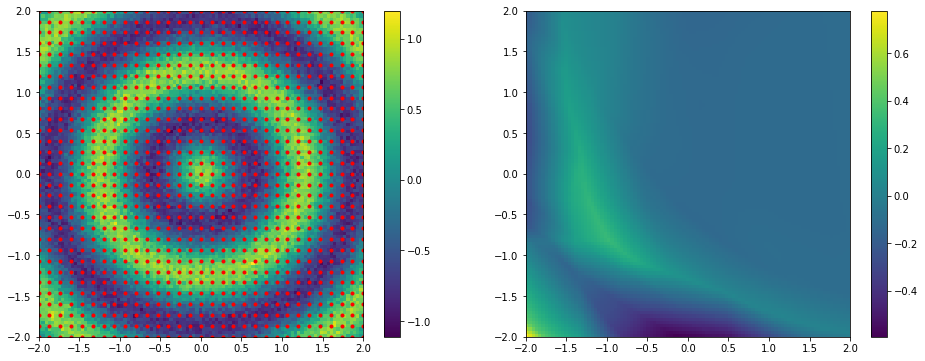

In [160]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=net.forward(x_test_2d)[0].reshape((n1,n1))
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


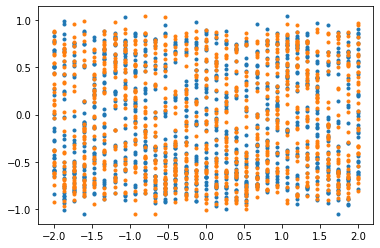

In [146]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
# hidden_layers=[64,128,128,64]
hidden_layers=[32,32,32,32]
n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
nnet=NNet(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,initialiser_function=initialiser_function2)

for ii in range(50):
    print(ii)
    nnet.train(x,y,print_error=False,alpha=0.01)
#     plt.plot(x_test,net.forward(x_test)[0])

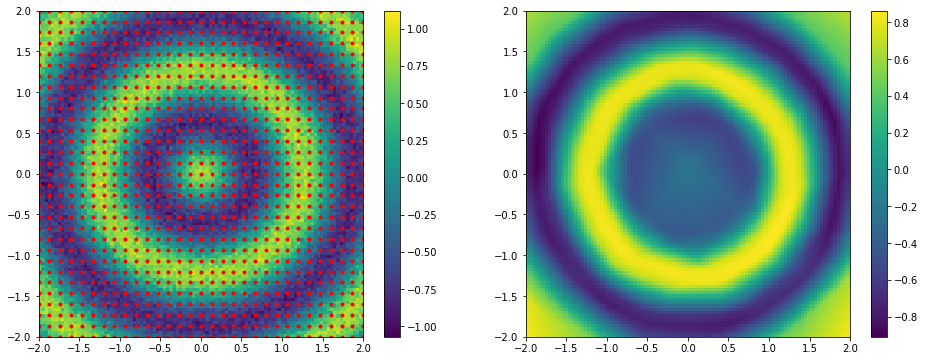

In [147]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=nnet.forward(x_test_2d).reshape((n1,n1))
# print(y_test_net_2d.shape)
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')


In [843]:
n_data=10001
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3.4)+np.random.randn(x.shape[0],x.shape[1])*0.1
net=NNet2(hidden_layer_sizes=[16,32,64],input_dim=1,output_dim=1,initialiser_function=initialiser_function2)
net.train(x,y,print_error=True)

0: Error: 334.35268309062906
1: Error: 554797.848962102
2: Error: 314101399663.7126
3: Error: 2.692941677171469e+51
4: Error: 1.4828564323933328e+202
5: Error: inf
6: Error: nan
7: Error: nan
8: Error: nan
9: Error: nan
10: Error: nan
11: Error: nan
12: Error: nan
13: Error: nan
14: Error: nan
15: Error: nan
16: Error: nan
17: Error: nan
18: Error: nan
19: Error: nan
20: Error: nan
21: Error: nan
22: Error: nan
23: Error: nan
24: Error: nan
25: Error: nan
26: Error: nan
27: Error: nan
28: Error: nan
29: Error: nan
30: Error: nan
31: Error: nan
32: Error: nan
33: Error: nan
34: Error: nan
35: Error: nan
36: Error: nan
37: Error: nan
38: Error: nan
39: Error: nan
40: Error: nan
41: Error: nan
42: Error: nan
43: Error: nan
44: Error: nan
45: Error: nan
46: Error: nan
47: Error: nan
48: Error: nan
49: Error: nan
50: Error: nan
51: Error: nan
52: Error: nan
53: Error: nan
54: Error: nan
55: Error: nan
56: Error: nan
57: Error: nan
58: Error: nan
59: Error: nan
60: Error: nan
61: Error: nan


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


239: Error: nan
240: Error: nan
241: Error: nan
242: Error: nan
243: Error: nan
244: Error: nan
245: Error: nan
246: Error: nan
247: Error: nan
248: Error: nan
249: Error: nan
250: Error: nan
251: Error: nan
252: Error: nan
253: Error: nan
254: Error: nan
255: Error: nan
256: Error: nan
257: Error: nan
258: Error: nan
259: Error: nan
260: Error: nan
261: Error: nan
262: Error: nan
263: Error: nan
264: Error: nan
265: Error: nan
266: Error: nan
267: Error: nan
268: Error: nan
269: Error: nan
270: Error: nan
271: Error: nan
272: Error: nan
273: Error: nan
274: Error: nan
275: Error: nan
276: Error: nan
277: Error: nan
278: Error: nan
279: Error: nan
280: Error: nan
281: Error: nan
282: Error: nan
283: Error: nan
284: Error: nan
285: Error: nan
286: Error: nan
287: Error: nan
288: Error: nan
289: Error: nan
290: Error: nan
291: Error: nan
292: Error: nan
293: Error: nan
294: Error: nan
295: Error: nan
296: Error: nan
297: Error: nan
298: Error: nan
299: Error: nan
300: Error: nan
301: Err

1277: Error: nan
1278: Error: nan
1279: Error: nan
1280: Error: nan
1281: Error: nan
1282: Error: nan
1283: Error: nan
1284: Error: nan
1285: Error: nan
1286: Error: nan
1287: Error: nan
1288: Error: nan
1289: Error: nan
1290: Error: nan
1291: Error: nan
1292: Error: nan
1293: Error: nan
1294: Error: nan
1295: Error: nan
1296: Error: nan
1297: Error: nan
1298: Error: nan
1299: Error: nan
1300: Error: nan
1301: Error: nan
1302: Error: nan
1303: Error: nan
1304: Error: nan
1305: Error: nan
1306: Error: nan
1307: Error: nan
1308: Error: nan
1309: Error: nan
1310: Error: nan
1311: Error: nan
1312: Error: nan
1313: Error: nan
1314: Error: nan
1315: Error: nan
1316: Error: nan
1317: Error: nan
1318: Error: nan
1319: Error: nan
1320: Error: nan
1321: Error: nan
1322: Error: nan
1323: Error: nan
1324: Error: nan
1325: Error: nan
1326: Error: nan
1327: Error: nan
1328: Error: nan
1329: Error: nan
1330: Error: nan
1331: Error: nan
1332: Error: nan
1333: Error: nan
1334: Error: nan
1335: Error: n

2099: Error: nan
2100: Error: nan
2101: Error: nan
2102: Error: nan
2103: Error: nan
2104: Error: nan
2105: Error: nan
2106: Error: nan
2107: Error: nan
2108: Error: nan
2109: Error: nan
2110: Error: nan
2111: Error: nan
2112: Error: nan
2113: Error: nan
2114: Error: nan
2115: Error: nan
2116: Error: nan
2117: Error: nan
2118: Error: nan
2119: Error: nan
2120: Error: nan
2121: Error: nan
2122: Error: nan
2123: Error: nan
2124: Error: nan
2125: Error: nan
2126: Error: nan
2127: Error: nan
2128: Error: nan
2129: Error: nan
2130: Error: nan
2131: Error: nan
2132: Error: nan
2133: Error: nan
2134: Error: nan
2135: Error: nan
2136: Error: nan
2137: Error: nan
2138: Error: nan
2139: Error: nan
2140: Error: nan
2141: Error: nan
2142: Error: nan
2143: Error: nan
2144: Error: nan
2145: Error: nan
2146: Error: nan
2147: Error: nan
2148: Error: nan
2149: Error: nan
2150: Error: nan
2151: Error: nan
2152: Error: nan
2153: Error: nan
2154: Error: nan
2155: Error: nan
2156: Error: nan
2157: Error: n

3012: Error: nan
3013: Error: nan
3014: Error: nan
3015: Error: nan
3016: Error: nan
3017: Error: nan
3018: Error: nan
3019: Error: nan
3020: Error: nan
3021: Error: nan
3022: Error: nan
3023: Error: nan
3024: Error: nan
3025: Error: nan
3026: Error: nan
3027: Error: nan
3028: Error: nan
3029: Error: nan
3030: Error: nan
3031: Error: nan
3032: Error: nan
3033: Error: nan
3034: Error: nan
3035: Error: nan
3036: Error: nan
3037: Error: nan
3038: Error: nan
3039: Error: nan
3040: Error: nan
3041: Error: nan
3042: Error: nan
3043: Error: nan
3044: Error: nan
3045: Error: nan
3046: Error: nan
3047: Error: nan
3048: Error: nan
3049: Error: nan
3050: Error: nan
3051: Error: nan
3052: Error: nan
3053: Error: nan
3054: Error: nan
3055: Error: nan
3056: Error: nan
3057: Error: nan
3058: Error: nan
3059: Error: nan
3060: Error: nan
3061: Error: nan
3062: Error: nan
3063: Error: nan
3064: Error: nan
3065: Error: nan
3066: Error: nan
3067: Error: nan
3068: Error: nan
3069: Error: nan
3070: Error: n

4011: Error: nan
4012: Error: nan
4013: Error: nan
4014: Error: nan
4015: Error: nan
4016: Error: nan
4017: Error: nan
4018: Error: nan
4019: Error: nan
4020: Error: nan
4021: Error: nan
4022: Error: nan
4023: Error: nan
4024: Error: nan
4025: Error: nan
4026: Error: nan
4027: Error: nan
4028: Error: nan
4029: Error: nan
4030: Error: nan
4031: Error: nan
4032: Error: nan
4033: Error: nan
4034: Error: nan
4035: Error: nan
4036: Error: nan
4037: Error: nan
4038: Error: nan
4039: Error: nan
4040: Error: nan
4041: Error: nan
4042: Error: nan
4043: Error: nan
4044: Error: nan
4045: Error: nan
4046: Error: nan
4047: Error: nan
4048: Error: nan
4049: Error: nan
4050: Error: nan
4051: Error: nan
4052: Error: nan
4053: Error: nan
4054: Error: nan
4055: Error: nan
4056: Error: nan
4057: Error: nan
4058: Error: nan
4059: Error: nan
4060: Error: nan
4061: Error: nan
4062: Error: nan
4063: Error: nan
4064: Error: nan
4065: Error: nan
4066: Error: nan
4067: Error: nan
4068: Error: nan
4069: Error: n

4560: Error: nan
4561: Error: nan
4562: Error: nan
4563: Error: nan
4564: Error: nan
4565: Error: nan
4566: Error: nan
4567: Error: nan
4568: Error: nan
4569: Error: nan
4570: Error: nan
4571: Error: nan
4572: Error: nan
4573: Error: nan
4574: Error: nan
4575: Error: nan
4576: Error: nan
4577: Error: nan
4578: Error: nan
4579: Error: nan
4580: Error: nan
4581: Error: nan
4582: Error: nan
4583: Error: nan
4584: Error: nan
4585: Error: nan
4586: Error: nan
4587: Error: nan
4588: Error: nan
4589: Error: nan
4590: Error: nan
4591: Error: nan
4592: Error: nan
4593: Error: nan
4594: Error: nan
4595: Error: nan
4596: Error: nan
4597: Error: nan
4598: Error: nan
4599: Error: nan
4600: Error: nan
4601: Error: nan
4602: Error: nan
4603: Error: nan
4604: Error: nan
4605: Error: nan
4606: Error: nan
4607: Error: nan
4608: Error: nan
4609: Error: nan
4610: Error: nan
4611: Error: nan
4612: Error: nan
4613: Error: nan
4614: Error: nan
4615: Error: nan
4616: Error: nan
4617: Error: nan
4618: Error: n

5042: Error: nan
5043: Error: nan
5044: Error: nan
5045: Error: nan
5046: Error: nan
5047: Error: nan
5048: Error: nan
5049: Error: nan
5050: Error: nan
5051: Error: nan
5052: Error: nan
5053: Error: nan
5054: Error: nan
5055: Error: nan
5056: Error: nan
5057: Error: nan
5058: Error: nan
5059: Error: nan
5060: Error: nan
5061: Error: nan
5062: Error: nan
5063: Error: nan
5064: Error: nan
5065: Error: nan
5066: Error: nan
5067: Error: nan
5068: Error: nan
5069: Error: nan
5070: Error: nan
5071: Error: nan
5072: Error: nan
5073: Error: nan
5074: Error: nan
5075: Error: nan
5076: Error: nan
5077: Error: nan
5078: Error: nan
5079: Error: nan
5080: Error: nan
5081: Error: nan
5082: Error: nan
5083: Error: nan
5084: Error: nan
5085: Error: nan
5086: Error: nan
5087: Error: nan
5088: Error: nan
5089: Error: nan
5090: Error: nan
5091: Error: nan
5092: Error: nan
5093: Error: nan
5094: Error: nan
5095: Error: nan
5096: Error: nan
5097: Error: nan
5098: Error: nan
5099: Error: nan
5100: Error: n

5524: Error: nan
5525: Error: nan
5526: Error: nan
5527: Error: nan
5528: Error: nan
5529: Error: nan
5530: Error: nan
5531: Error: nan
5532: Error: nan
5533: Error: nan
5534: Error: nan
5535: Error: nan
5536: Error: nan
5537: Error: nan
5538: Error: nan
5539: Error: nan
5540: Error: nan
5541: Error: nan
5542: Error: nan
5543: Error: nan
5544: Error: nan
5545: Error: nan
5546: Error: nan
5547: Error: nan
5548: Error: nan
5549: Error: nan
5550: Error: nan
5551: Error: nan
5552: Error: nan
5553: Error: nan
5554: Error: nan
5555: Error: nan
5556: Error: nan
5557: Error: nan
5558: Error: nan
5559: Error: nan
5560: Error: nan
5561: Error: nan
5562: Error: nan
5563: Error: nan
5564: Error: nan
5565: Error: nan
5566: Error: nan
5567: Error: nan
5568: Error: nan
5569: Error: nan
5570: Error: nan
5571: Error: nan
5572: Error: nan
5573: Error: nan
5574: Error: nan
5575: Error: nan
5576: Error: nan
5577: Error: nan
5578: Error: nan
5579: Error: nan
5580: Error: nan
5581: Error: nan
5582: Error: n

6045: Error: nan
6046: Error: nan
6047: Error: nan
6048: Error: nan
6049: Error: nan
6050: Error: nan
6051: Error: nan
6052: Error: nan
6053: Error: nan
6054: Error: nan
6055: Error: nan
6056: Error: nan
6057: Error: nan
6058: Error: nan
6059: Error: nan
6060: Error: nan
6061: Error: nan
6062: Error: nan
6063: Error: nan
6064: Error: nan
6065: Error: nan
6066: Error: nan
6067: Error: nan
6068: Error: nan
6069: Error: nan
6070: Error: nan
6071: Error: nan
6072: Error: nan
6073: Error: nan
6074: Error: nan
6075: Error: nan
6076: Error: nan
6077: Error: nan
6078: Error: nan
6079: Error: nan
6080: Error: nan
6081: Error: nan
6082: Error: nan
6083: Error: nan
6084: Error: nan
6085: Error: nan
6086: Error: nan
6087: Error: nan
6088: Error: nan
6089: Error: nan
6090: Error: nan
6091: Error: nan
6092: Error: nan
6093: Error: nan
6094: Error: nan
6095: Error: nan
6096: Error: nan
6097: Error: nan
6098: Error: nan
6099: Error: nan
6100: Error: nan
6101: Error: nan
6102: Error: nan
6103: Error: n

6615: Error: nan
6616: Error: nan
6617: Error: nan
6618: Error: nan
6619: Error: nan
6620: Error: nan
6621: Error: nan
6622: Error: nan
6623: Error: nan
6624: Error: nan
6625: Error: nan
6626: Error: nan
6627: Error: nan
6628: Error: nan
6629: Error: nan
6630: Error: nan
6631: Error: nan
6632: Error: nan
6633: Error: nan
6634: Error: nan
6635: Error: nan
6636: Error: nan
6637: Error: nan
6638: Error: nan
6639: Error: nan
6640: Error: nan
6641: Error: nan
6642: Error: nan
6643: Error: nan
6644: Error: nan
6645: Error: nan
6646: Error: nan
6647: Error: nan
6648: Error: nan
6649: Error: nan
6650: Error: nan
6651: Error: nan
6652: Error: nan
6653: Error: nan
6654: Error: nan
6655: Error: nan
6656: Error: nan
6657: Error: nan
6658: Error: nan
6659: Error: nan
6660: Error: nan
6661: Error: nan
6662: Error: nan
6663: Error: nan
6664: Error: nan
6665: Error: nan
6666: Error: nan
6667: Error: nan
6668: Error: nan
6669: Error: nan
6670: Error: nan
6671: Error: nan
6672: Error: nan
6673: Error: n

7157: Error: nan
7158: Error: nan
7159: Error: nan
7160: Error: nan
7161: Error: nan
7162: Error: nan
7163: Error: nan
7164: Error: nan
7165: Error: nan
7166: Error: nan
7167: Error: nan
7168: Error: nan
7169: Error: nan
7170: Error: nan
7171: Error: nan
7172: Error: nan
7173: Error: nan
7174: Error: nan
7175: Error: nan
7176: Error: nan
7177: Error: nan
7178: Error: nan
7179: Error: nan
7180: Error: nan
7181: Error: nan
7182: Error: nan
7183: Error: nan
7184: Error: nan
7185: Error: nan
7186: Error: nan
7187: Error: nan
7188: Error: nan
7189: Error: nan
7190: Error: nan
7191: Error: nan
7192: Error: nan
7193: Error: nan
7194: Error: nan
7195: Error: nan
7196: Error: nan
7197: Error: nan
7198: Error: nan
7199: Error: nan
7200: Error: nan
7201: Error: nan
7202: Error: nan
7203: Error: nan
7204: Error: nan
7205: Error: nan
7206: Error: nan
7207: Error: nan
7208: Error: nan
7209: Error: nan
7210: Error: nan
7211: Error: nan
7212: Error: nan
7213: Error: nan
7214: Error: nan
7215: Error: n

7986: Error: nan
7987: Error: nan
7988: Error: nan
7989: Error: nan
7990: Error: nan
7991: Error: nan
7992: Error: nan
7993: Error: nan
7994: Error: nan
7995: Error: nan
7996: Error: nan
7997: Error: nan
7998: Error: nan
7999: Error: nan
8000: Error: nan
8001: Error: nan
8002: Error: nan
8003: Error: nan
8004: Error: nan
8005: Error: nan
8006: Error: nan
8007: Error: nan
8008: Error: nan
8009: Error: nan
8010: Error: nan
8011: Error: nan
8012: Error: nan
8013: Error: nan
8014: Error: nan
8015: Error: nan
8016: Error: nan
8017: Error: nan
8018: Error: nan
8019: Error: nan
8020: Error: nan
8021: Error: nan
8022: Error: nan
8023: Error: nan
8024: Error: nan
8025: Error: nan
8026: Error: nan
8027: Error: nan
8028: Error: nan
8029: Error: nan
8030: Error: nan
8031: Error: nan
8032: Error: nan
8033: Error: nan
8034: Error: nan
8035: Error: nan
8036: Error: nan
8037: Error: nan
8038: Error: nan
8039: Error: nan
8040: Error: nan
8041: Error: nan
8042: Error: nan
8043: Error: nan
8044: Error: n

8586: Error: nan
8587: Error: nan
8588: Error: nan
8589: Error: nan
8590: Error: nan
8591: Error: nan
8592: Error: nan
8593: Error: nan
8594: Error: nan
8595: Error: nan
8596: Error: nan
8597: Error: nan
8598: Error: nan
8599: Error: nan
8600: Error: nan
8601: Error: nan
8602: Error: nan
8603: Error: nan
8604: Error: nan
8605: Error: nan
8606: Error: nan
8607: Error: nan
8608: Error: nan
8609: Error: nan
8610: Error: nan
8611: Error: nan
8612: Error: nan
8613: Error: nan
8614: Error: nan
8615: Error: nan
8616: Error: nan
8617: Error: nan
8618: Error: nan
8619: Error: nan
8620: Error: nan
8621: Error: nan
8622: Error: nan
8623: Error: nan
8624: Error: nan
8625: Error: nan
8626: Error: nan
8627: Error: nan
8628: Error: nan
8629: Error: nan
8630: Error: nan
8631: Error: nan
8632: Error: nan
8633: Error: nan
8634: Error: nan
8635: Error: nan
8636: Error: nan
8637: Error: nan
8638: Error: nan
8639: Error: nan
8640: Error: nan
8641: Error: nan
8642: Error: nan
8643: Error: nan
8644: Error: n

9106: Error: nan
9107: Error: nan
9108: Error: nan
9109: Error: nan
9110: Error: nan
9111: Error: nan
9112: Error: nan
9113: Error: nan
9114: Error: nan
9115: Error: nan
9116: Error: nan
9117: Error: nan
9118: Error: nan
9119: Error: nan
9120: Error: nan
9121: Error: nan
9122: Error: nan
9123: Error: nan
9124: Error: nan
9125: Error: nan
9126: Error: nan
9127: Error: nan
9128: Error: nan
9129: Error: nan
9130: Error: nan
9131: Error: nan
9132: Error: nan
9133: Error: nan
9134: Error: nan
9135: Error: nan
9136: Error: nan
9137: Error: nan
9138: Error: nan
9139: Error: nan
9140: Error: nan
9141: Error: nan
9142: Error: nan
9143: Error: nan
9144: Error: nan
9145: Error: nan
9146: Error: nan
9147: Error: nan
9148: Error: nan
9149: Error: nan
9150: Error: nan
9151: Error: nan
9152: Error: nan
9153: Error: nan
9154: Error: nan
9155: Error: nan
9156: Error: nan
9157: Error: nan
9158: Error: nan
9159: Error: nan
9160: Error: nan
9161: Error: nan
9162: Error: nan
9163: Error: nan
9164: Error: n

(1000, 1)


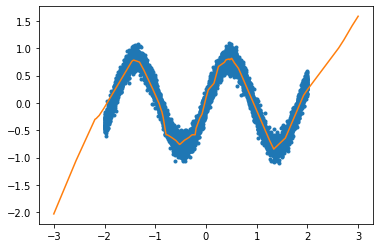

In [805]:
x_test=np.linspace(-3,3,1000).reshape(1000,1)
plt.plot(x,y,'.')
plt.plot(x_test,net.forward(x_test))
